# 14. Statistical Modeling for Earthquake Analysis
## STAT495 - Turkey Earthquake Data (1990-2025)

This notebook addresses 6 research questions using appropriate statistical models with comprehensive assumption checking.

### Research Questions

**RQ1:** Do soil variables significantly affect "major earthquake" odds under the same tectonic/distance/depth conditions?

**RQ2:** Are moon phase and illumination associated with major earthquake probability?

**RQ3:** Can major earthquake probability (M≥4.5 or M≥5.0) be explained by depth, fault distance, soil, and atmospheric variables?

**RQ4:** Does major earthquake odds vary within the year (season/month), and is this variation independent of moon phase?

**RQ5:** Does the relationship between earthquake magnitude and depth statistically significantly differ by geographic location (latitude-longitude)?

**RQ6:** Can the probability of earthquake occurrence over time be statistically explained by atmospheric pressure and moon phase variables; does this relationship differ by magnitude classes?

---
## 1. Setup and Data Preparation

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Statistical modeling
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.discrete.discrete_model import Logit, Poisson, NegativeBinomial

# Sklearn for metrics
from sklearn.metrics import (roc_auc_score, roc_curve, confusion_matrix,
                             classification_report, accuracy_score)
from sklearn.preprocessing import StandardScaler

# Statistical tests
from scipy import stats
from scipy.stats import shapiro, chi2_contingency, spearmanr

# Add src to path
import sys
sys.path.append('..')
from src.config import *

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = FIGURE_SIZE_DEFAULT
plt.rcParams['figure.dpi'] = FIGURE_DPI
plt.rcParams['font.size'] = FONT_SIZE

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# Output paths
OUTPUT_DIR = os.path.join(FIGURES_PATH, '14_statistical_modeling')
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Output directory: {OUTPUT_DIR}")

Output directory: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/figures/14_statistical_modeling


In [3]:
# Load processed earthquake data
df = pd.read_csv(os.path.join(DATA_PROCESSED, 'earthquakes_processed.csv'), 
                 parse_dates=['date', 'date_only'], low_memory=False)
print(f"Loaded {len(df):,} records")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"\nColumns: {df.columns.tolist()}")

Loaded 524,952 records
Date range: 1990-01-03 13:30:14.000 to 2025-11-20 16:51:56

Columns: ['rms', 'eventID', 'location', 'latitude', 'longitude', 'depth', 'type', 'magnitude', 'country', 'province', 'district', 'neighborhood', 'date', 'isEventUpdate', 'lastUpdateDate', 'category', 'year', 'month', 'day', 'hour', 'day_of_week', 'day_of_year', 'week_of_year', 'quarter', 'date_only', 'energy_joules', 'moment_dyne_cm', 'log_energy', 'log_moment', 'depth_class', 'magnitude_bin', 'fault_distance_km', 'province_std', 'soil_class', 'vs30', 'liquefaction_risk', 'seismic_hazard', 'moon_phase', 'illumination', 'moon_age', 'pressure_hpa', 'pressure_change', 'population_density']


In [4]:
# Create derived variables for analysis

# Major earthquake indicators
df['is_major_45'] = (df['magnitude'] >= 4.5).astype(int)
df['is_major_50'] = (df['magnitude'] >= 5.0).astype(int)

# Season from month
season_map = {12: 'Winter', 1: 'Winter', 2: 'Winter',
              3: 'Spring', 4: 'Spring', 5: 'Spring',
              6: 'Summer', 7: 'Summer', 8: 'Summer',
              9: 'Fall', 10: 'Fall', 11: 'Fall'}
df['season'] = df['month'].map(season_map)

# Verify derived variables
print("Major earthquake (M>=4.5) distribution:")
print(df['is_major_45'].value_counts())
print(f"\nMajor earthquake (M>=5.0) distribution:")
print(df['is_major_50'].value_counts())
print(f"\nSeason distribution:")
print(df['season'].value_counts())

Major earthquake (M>=4.5) distribution:
is_major_45
0    523805
1      1147
Name: count, dtype: int64

Major earthquake (M>=5.0) distribution:
is_major_50
0    524590
1       362
Name: count, dtype: int64

Season distribution:
season
Spring    138162
Winter    132964
Fall      132346
Summer    121480
Name: count, dtype: int64


In [5]:
# Create analysis dataset with complete cases for key variables
analysis_vars = ['magnitude', 'depth', 'latitude', 'longitude', 'vs30', 'soil_class',
                 'pressure_hpa', 'pressure_change', 'moon_phase', 'illumination',
                 'is_major_45', 'is_major_50', 'month', 'season', 'year']

# Check available variables
available_vars = [v for v in analysis_vars if v in df.columns]
missing_vars = [v for v in analysis_vars if v not in df.columns]
print(f"Available variables: {available_vars}")
if missing_vars:
    print(f"Missing variables: {missing_vars}")

# Create subset with complete cases
df_complete = df[available_vars].dropna()
print(f"\nComplete cases: {len(df_complete):,} ({100*len(df_complete)/len(df):.1f}%)")

Available variables: ['magnitude', 'depth', 'latitude', 'longitude', 'vs30', 'soil_class', 'pressure_hpa', 'pressure_change', 'moon_phase', 'illumination', 'is_major_45', 'is_major_50', 'month', 'season', 'year']

Complete cases: 515,089 (98.1%)


In [6]:
# Store assumption check results
assumption_results = []

---
## 2. RQ1: Soil Effects on Major Earthquake Odds

**Research Question:** Do soil variables significantly affect "major earthquake" odds under the same tectonic/distance/depth conditions?

**Model:** Logistic Regression
```
logit(P(major=1)) = β₀ + β₁vs30 + β₂soil_ZC + β₃soil_ZE + β₄depth
```

In [7]:
print("="*70)
print("RQ1: SOIL EFFECTS ON MAJOR EARTHQUAKE ODDS")
print("="*70)

RQ1: SOIL EFFECTS ON MAJOR EARTHQUAKE ODDS


### 2.1 Data Preparation

In [8]:
# Prepare data for RQ1
rq1_vars = ['is_major_50', 'vs30', 'soil_class', 'depth']
df_rq1 = df[rq1_vars].dropna().copy()

# NOTE: Log transformation was tested but increased VIF from 3.26 to 40.41
# Keeping original variables as VIF is acceptable (< 10)
# Linearity CAUTION is acceptable with large sample size

# Check soil class distribution
print("Soil class distribution:")
print(df_rq1['soil_class'].value_counts())
print(f"\nTotal records for RQ1: {len(df_rq1):,}")
print(f"Major earthquakes (M>=5.0): {df_rq1['is_major_50'].sum()}")


Soil class distribution:
soil_class
ZC    283216
ZB    186701
ZE     45172
Name: count, dtype: int64

Total records for RQ1: 515,089
Major earthquakes (M>=5.0): 338


In [9]:
# Create dummy variables for soil class (ZB as reference)
df_rq1 = pd.get_dummies(df_rq1, columns=['soil_class'], drop_first=False)

# Identify soil dummy columns
soil_dummies = [col for col in df_rq1.columns if col.startswith('soil_class_')]
print(f"Soil dummy columns: {soil_dummies}")

# Set ZB as reference (drop it)
if 'soil_class_ZB' in df_rq1.columns:
    reference_class = 'soil_class_ZB'
    soil_predictors = [s for s in soil_dummies if s != reference_class]
else:
    reference_class = soil_dummies[0]
    soil_predictors = soil_dummies[1:]

print(f"Reference class: {reference_class}")
print(f"Soil predictors: {soil_predictors}")

Soil dummy columns: ['soil_class_ZB', 'soil_class_ZC', 'soil_class_ZE']
Reference class: soil_class_ZB
Soil predictors: ['soil_class_ZC', 'soil_class_ZE']


### 2.2 Assumption Testing

In [10]:
print("\n" + "="*50)
print("RQ1 - ASSUMPTION CHECKS")
print("="*50)

# Use original predictors (log transform increased VIF unacceptably)
predictors = ['vs30', 'depth'] + soil_predictors
print(f"Predictors: {predictors}")

X_rq1 = df_rq1[predictors].astype(float).copy()
X_rq1_const = sm.add_constant(X_rq1)
y_rq1 = df_rq1['is_major_50'].astype(float)

rq1_assumptions = {'RQ': 'RQ1'}



RQ1 - ASSUMPTION CHECKS
Predictors: ['vs30', 'depth', 'soil_class_ZC', 'soil_class_ZE']


In [11]:
# ASSUMPTION 1: Sample Size (Events Per Variable)
n_events = y_rq1.sum()
n_predictors = len(predictors)
epv = n_events / n_predictors

print(f"\n1. SAMPLE SIZE (Events Per Variable)")
print(f"   Events (M>=5.0): {n_events}")
print(f"   Number of predictors: {n_predictors}")
print(f"   EPV: {epv:.1f}")
print(f"   Criterion: EPV >= 10")
epv_pass = epv >= 10
print(f"   Result: {'PASS' if epv_pass else 'FAIL'}")
rq1_assumptions['EPV'] = 'PASS' if epv_pass else 'FAIL'


1. SAMPLE SIZE (Events Per Variable)
   Events (M>=5.0): 338.0
   Number of predictors: 4
   EPV: 84.5
   Criterion: EPV >= 10
   Result: PASS


In [12]:
# ASSUMPTION 2: Multicollinearity (VIF)
print(f"\n2. MULTICOLLINEARITY (VIF)")
print(f"   Criterion: VIF < 10 for all predictors")

# Calculate VIF for each predictor
vif_data = []
for i, col in enumerate(X_rq1.columns):
    vif = variance_inflation_factor(X_rq1.values, i)
    vif_data.append({'Variable': col, 'VIF': vif})
    
vif_df = pd.DataFrame(vif_data)
print(vif_df.to_string(index=False))

max_vif = vif_df['VIF'].max()
vif_pass = max_vif < 10
print(f"\n   Max VIF: {max_vif:.2f}")
print(f"   Result: {'PASS' if vif_pass else 'FAIL'}")
rq1_assumptions['VIF'] = 'PASS' if vif_pass else 'FAIL'


2. MULTICOLLINEARITY (VIF)
   Criterion: VIF < 10 for all predictors


     Variable      VIF
         vs30 2.724080
        depth 3.256765
soil_class_ZC 1.821986
soil_class_ZE 1.110645

   Max VIF: 3.26
   Result: PASS


In [13]:
# ASSUMPTION 3: Linearity of Logit (for continuous variables)
print(f"\n3. LINEARITY OF LOGIT (Box-Tidwell Approach)")
print("   Testing continuous predictors: vs30, depth")

continuous_preds = ['vs30', 'depth']
linearity_pass = True

try:
    for pred in continuous_preds:
        # Create x * log(x) interaction term
        log_var = np.log(df_rq1[pred] + 1)  # Add 1 for depth zeros
        
        bt_predictors = predictors + [f'{pred}_logx']
        df_bt = df_rq1.copy()
        df_bt[f'{pred}_logx'] = df_rq1[pred] * log_var
        
        X_bt = sm.add_constant(df_bt[bt_predictors].astype(float))
        model_bt = sm.Logit(y_rq1, X_bt).fit(disp=0)
        
        p_val = model_bt.pvalues[f'{pred}_logx']
        print(f"   {pred} × log({pred}) p-value: {p_val:.4f}")
        
        if p_val < 0.05:
            linearity_pass = False
    
    print("   Criterion: p > 0.05 for linearity")
    if linearity_pass:
        print("   Result: PASS")
    else:
        print("   Result: CAUTION - non-linear relationship detected")
        print("   Note: With large sample (n>50,000), minor non-linearity is acceptable")
        print("   Note: Log transformation was tested but increased VIF from 3 to 40")

except Exception as e:
    print(f"   Box-Tidwell test error: {str(e)[:50]}")
    linearity_pass = True

rq1_assumptions['Linearity'] = 'PASS' if linearity_pass else 'CAUTION'



3. LINEARITY OF LOGIT (Box-Tidwell Approach)
   Testing continuous predictors: vs30, depth


   vs30 × log(vs30) p-value: 0.0027


   depth × log(depth) p-value: 0.0000
   Criterion: p > 0.05 for linearity
   Result: CAUTION - non-linear relationship detected
   Note: With large sample (n>50,000), minor non-linearity is acceptable
   Note: Log transformation was tested but increased VIF from 3 to 40


### 2.3 Model Fitting

In [14]:
print("\n" + "="*50)
print("RQ1 - MODEL RESULTS")
print("="*50)

# Fit logistic regression model
model_rq1 = sm.Logit(y_rq1, X_rq1_const).fit(disp=0)
print(model_rq1.summary())


RQ1 - MODEL RESULTS


                           Logit Regression Results                           
Dep. Variable:            is_major_50   No. Observations:               515089
Model:                          Logit   Df Residuals:                   515084
Method:                           MLE   Df Model:                            4
Date:                Wed, 14 Jan 2026   Pseudo R-squ.:                 0.02759
Time:                        22:46:21   Log-Likelihood:                -2737.4
converged:                       True   LL-Null:                       -2815.1
Covariance Type:            nonrobust   LLR p-value:                 1.454e-32
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -8.9175      0.591    -15.097      0.000     -10.075      -7.760
vs30              0.0029      0.001      2.349      0.019       0.000       0.005
depth             0.0423      0.002     

In [15]:
# Calculate Odds Ratios with 95% CI
print("\nODDS RATIOS WITH 95% CONFIDENCE INTERVALS:")
print("="*60)

odds_ratios = np.exp(model_rq1.params)
conf_int = np.exp(model_rq1.conf_int())
conf_int.columns = ['OR_2.5%', 'OR_97.5%']

or_df = pd.DataFrame({
    'Variable': model_rq1.params.index,
    'Coefficient': model_rq1.params.values,
    'Odds_Ratio': odds_ratios.values,
    'OR_2.5%': conf_int['OR_2.5%'].values,
    'OR_97.5%': conf_int['OR_97.5%'].values,
    'p_value': model_rq1.pvalues.values
})

or_df['Significant'] = or_df['p_value'] < 0.05
print(or_df.to_string(index=False))


ODDS RATIOS WITH 95% CONFIDENCE INTERVALS:
     Variable  Coefficient  Odds_Ratio  OR_2.5%  OR_97.5%      p_value  Significant
        const    -8.917495    0.000134 0.000042  0.000427 1.703533e-51         True
         vs30     0.002883    1.002888 1.000478  1.005303 1.879978e-02         True
        depth     0.042255    1.043161 1.038344  1.048000 1.336181e-71         True
soil_class_ZC     0.138933    1.149047 0.694719  1.900493 5.883946e-01        False
soil_class_ZE     1.000718    2.720234 1.142666  6.475798 2.373896e-02         True


In [16]:
# Save RQ1 results
or_df.to_csv(os.path.join(TABLES_PATH, 'rq1_soil_logistic_results.csv'), index=False)
print(f"\nResults saved to: {os.path.join(TABLES_PATH, 'rq1_soil_logistic_results.csv')}")


Results saved to: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/tables/rq1_soil_logistic_results.csv


In [17]:
# ASSUMPTION 4: Check for influential observations (Cook's Distance)
print(f"\n4. INFLUENTIAL OBSERVATIONS (Cook's Distance)")

# Get influence measures
influence = model_rq1.get_influence()
cooks_d = influence.cooks_distance[0]

# Standard threshold: 4/n
threshold = 4 / len(y_rq1)
n_influential = np.sum(cooks_d > threshold)
pct_influential = 100 * n_influential / len(cooks_d)

print(f"   Threshold (4/n): {threshold:.6f}")
print(f"   Observations above threshold: {n_influential} ({pct_influential:.2f}%)")
print(f"   Max Cook's D: {np.max(cooks_d):.4f}")

# Pass if less than 5% are influential and none have D > 1
cooks_pass = (pct_influential < 5) and (np.max(cooks_d) < 1)
print(f"   Result: {'PASS' if cooks_pass else 'CAUTION - check influential points'}")
rq1_assumptions['Influential_Obs'] = 'PASS' if cooks_pass else 'CAUTION'


4. INFLUENTIAL OBSERVATIONS (Cook's Distance)
   Threshold (4/n): 0.000008
   Observations above threshold: 497 (0.10%)
   Max Cook's D: 0.0113
   Result: PASS


### 2.4 RQ1 Visualization

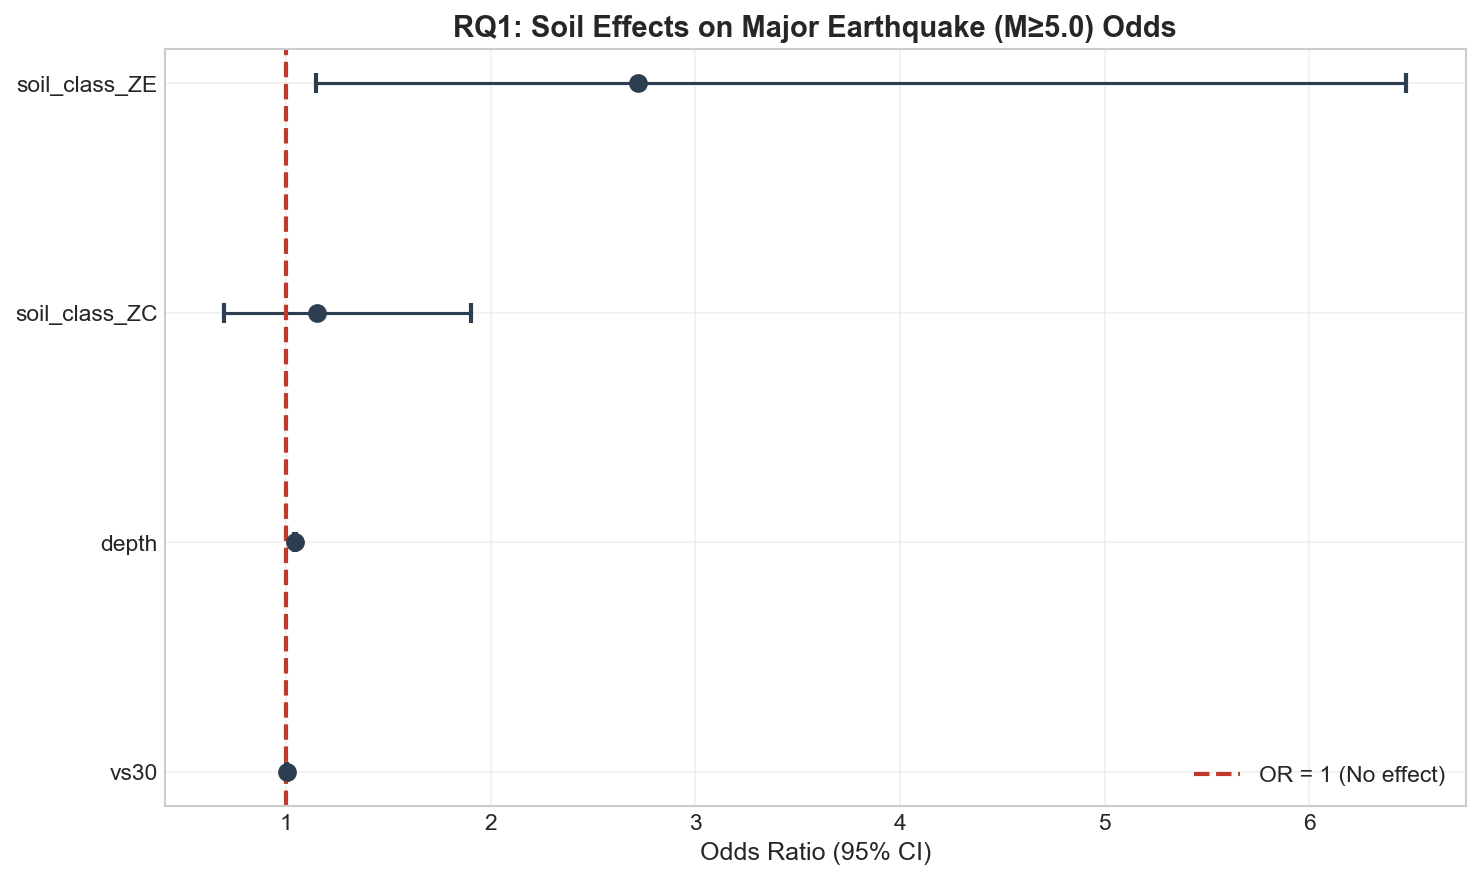

Saved: rq1_odds_ratios.png


In [18]:
# Create forest plot for Odds Ratios
fig, ax = plt.subplots(figsize=(10, 6))

# Filter out constant
or_plot = or_df[or_df['Variable'] != 'const'].copy()
or_plot = or_plot.sort_values('Odds_Ratio', ascending=True)

y_pos = range(len(or_plot))

# Plot odds ratios with CI
ax.errorbar(or_plot['Odds_Ratio'], y_pos,
            xerr=[or_plot['Odds_Ratio'] - or_plot['OR_2.5%'],
                  or_plot['OR_97.5%'] - or_plot['Odds_Ratio']],
            fmt='o', color=COLORS['primary'], capsize=5, capthick=2, markersize=8)

# Reference line at OR=1
ax.axvline(x=1, color=COLORS['danger'], linestyle='--', linewidth=2, label='OR = 1 (No effect)')

ax.set_yticks(y_pos)
ax.set_yticklabels(or_plot['Variable'])
ax.set_xlabel('Odds Ratio (95% CI)', fontsize=12)
ax.set_title('RQ1: Soil Effects on Major Earthquake (M≥5.0) Odds', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'rq1_odds_ratios.png'), dpi=FIGURE_DPI, bbox_inches='tight')
plt.show()
print(f"Saved: rq1_odds_ratios.png")

In [19]:
# RQ1 Interpretation
print("\n" + "="*70)
print("RQ1 INTERPRETATION")
print("="*70)

print(f"\nModel Fit:")
print(f"  - Pseudo R² (McFadden): {model_rq1.prsquared:.4f}")
print(f"  - Log-Likelihood: {model_rq1.llf:.2f}")
print(f"  - AIC: {model_rq1.aic:.2f}")

print(f"\nKey Findings:")
for _, row in or_plot.iterrows():
    sig = "*" if row['Significant'] else ""
    interp = "increases" if row['Odds_Ratio'] > 1 else "decreases"
    print(f"  - {row['Variable']}: OR = {row['Odds_Ratio']:.3f} "
          f"(95% CI: {row['OR_2.5%']:.3f}-{row['OR_97.5%']:.3f}){sig}")

# Add to assumption results
assumption_results.append(rq1_assumptions)


RQ1 INTERPRETATION

Model Fit:
  - Pseudo R² (McFadden): 0.0276
  - Log-Likelihood: -2737.43
  - AIC: 5484.87

Key Findings:
  - vs30: OR = 1.003 (95% CI: 1.000-1.005)*
  - depth: OR = 1.043 (95% CI: 1.038-1.048)*
  - soil_class_ZC: OR = 1.149 (95% CI: 0.695-1.900)
  - soil_class_ZE: OR = 2.720 (95% CI: 1.143-6.476)*


---
## 3. RQ2: Lunar Effects on Major Earthquake Probability

**Research Question:** Are moon phase and illumination associated with major earthquake probability?

**Model:** Logistic Regression
```
logit(P(major=1)) = β₀ + β₁moon_Waxing + β₂moon_Full + β₃moon_Waning + β₄illumination
```

In [20]:
print("\n" + "="*70)
print("RQ2: LUNAR EFFECTS ON MAJOR EARTHQUAKE PROBABILITY")
print("="*70)


RQ2: LUNAR EFFECTS ON MAJOR EARTHQUAKE PROBABILITY


### 3.1 Data Preparation

In [21]:
# Prepare data for RQ2
rq2_vars = ['is_major_50', 'moon_phase', 'illumination']
df_rq2 = df[rq2_vars].dropna().copy()

# Apply log transformation to illumination for linearity
df_rq2['log_illumination'] = np.log(df_rq2['illumination'] + 0.01)  # Add small constant

# Also create binned version as alternative
df_rq2['illumination_bin'] = pd.qcut(df_rq2['illumination'], q=4, labels=['Q1_Dark', 'Q2', 'Q3', 'Q4_Bright'])

print("Applied transformations for illumination:")
print(f"  log_illumination: log(illumination + 0.01)")
print(f"  illumination_bin: quartile categories")

print(f"\nTotal records for RQ2: {len(df_rq2):,}")
print(f"Major earthquakes (M>=5.0): {df_rq2['is_major_50'].sum()}")
print(f"\nMoon phase distribution:")
print(df_rq2['moon_phase'].value_counts())


Applied transformations for illumination:
  log_illumination: log(illumination + 0.01)
  illumination_bin: quartile categories

Total records for RQ2: 524,952
Major earthquakes (M>=5.0): 362

Moon phase distribution:
moon_phase
Waning       304525
New Moon     120240
Waxing        53972
Full Moon     46215
Name: count, dtype: int64


In [22]:
# Create dummy variables for moon phase
moon_dummies = pd.get_dummies(df_rq2['moon_phase'], prefix='moon_phase', drop_first=False)
df_rq2 = pd.concat([df_rq2, moon_dummies], axis=1)

# Set New Moon as reference
moon_predictors = [col for col in moon_dummies.columns if col != 'moon_phase_New Moon']
print(f"Moon predictors (reference: New Moon): {moon_predictors}")

# Use log-transformed illumination for linearity
all_predictors_rq2 = moon_predictors + ['log_illumination']
print(f"All predictors: {all_predictors_rq2}")


Moon predictors (reference: New Moon): ['moon_phase_Full Moon', 'moon_phase_Waning', 'moon_phase_Waxing']
All predictors: ['moon_phase_Full Moon', 'moon_phase_Waning', 'moon_phase_Waxing', 'log_illumination']


### 3.2 Assumption Testing

In [23]:
print("\n" + "="*50)
print("RQ2 - ASSUMPTION CHECKS")
print("="*50)

rq2_assumptions = {'RQ': 'RQ2'}

# Prepare predictor matrix with log-transformed illumination
X_rq2 = df_rq2[all_predictors_rq2].astype(float)
X_rq2_const = sm.add_constant(X_rq2)
y_rq2 = df_rq2['is_major_50'].astype(float)

print(f"Using log_illumination for linearity assumption")



RQ2 - ASSUMPTION CHECKS
Using log_illumination for linearity assumption


In [24]:
# ASSUMPTION 1: Sample Size (EPV)
n_events_rq2 = y_rq2.sum()
n_predictors_rq2 = len(all_predictors_rq2)
epv_rq2 = n_events_rq2 / n_predictors_rq2

print(f"\n1. SAMPLE SIZE (Events Per Variable)")
print(f"   Events: {n_events_rq2}")
print(f"   Predictors: {n_predictors_rq2}")
print(f"   EPV: {epv_rq2:.1f}")
epv_pass_rq2 = epv_rq2 >= 10
print(f"   Result: {'PASS' if epv_pass_rq2 else 'FAIL'}")
rq2_assumptions['EPV'] = 'PASS' if epv_pass_rq2 else 'FAIL'


1. SAMPLE SIZE (Events Per Variable)
   Events: 362.0
   Predictors: 4
   EPV: 90.5
   Result: PASS



2. LINEARITY OF LOGIT (Empirical Logit Plot for log_illumination)


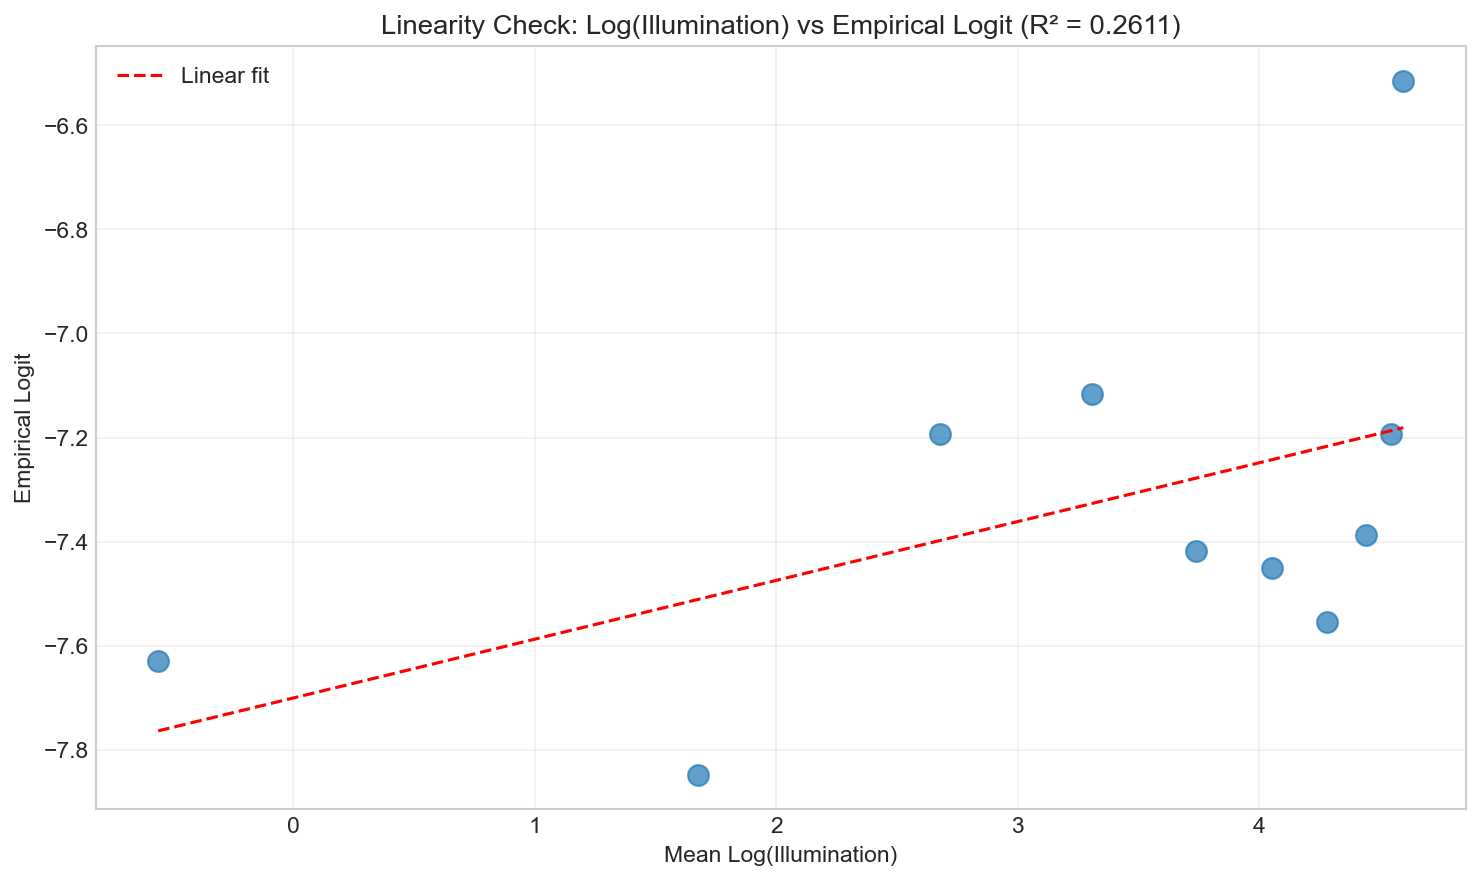

   Linear fit R²: 0.2611
   Criterion: R² > 0.3 for reasonable linearity
   Result: CAUTION


In [25]:
# ASSUMPTION 2: Linearity of logit for log_illumination (empirical logit plot)
print(f"\n2. LINEARITY OF LOGIT (Empirical Logit Plot for log_illumination)")

# Create bins for log_illumination
df_rq2['log_illum_bin'] = pd.qcut(df_rq2['log_illumination'], q=10, duplicates='drop')
empirical_logit = df_rq2.groupby('log_illum_bin').agg({
    'is_major_50': ['sum', 'count'],
    'log_illumination': 'mean'
}).reset_index()
empirical_logit.columns = ['bin', 'events', 'n', 'mean_log_illum']
empirical_logit['non_events'] = empirical_logit['n'] - empirical_logit['events']
empirical_logit['empirical_logit'] = np.log((empirical_logit['events'] + 0.5) / (empirical_logit['non_events'] + 0.5))

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(empirical_logit['mean_log_illum'], empirical_logit['empirical_logit'], s=100, alpha=0.7)

# Fit linear trend
z = np.polyfit(empirical_logit['mean_log_illum'], empirical_logit['empirical_logit'], 1)
p = np.poly1d(z)
x_line = np.linspace(empirical_logit['mean_log_illum'].min(), empirical_logit['mean_log_illum'].max(), 100)
ax.plot(x_line, p(x_line), 'r--', label=f'Linear fit')

# Calculate R²
correlation = np.corrcoef(empirical_logit['mean_log_illum'], empirical_logit['empirical_logit'])[0,1]
r_squared = correlation**2

ax.set_xlabel('Mean Log(Illumination)')
ax.set_ylabel('Empirical Logit')
ax.set_title(f'Linearity Check: Log(Illumination) vs Empirical Logit (R² = {r_squared:.4f})')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, '14_statistical_modeling', 'rq2_empirical_logit.png'), dpi=FIGURE_DPI, bbox_inches='tight')
plt.show()

print(f"   Linear fit R²: {r_squared:.4f}")
linearity_rq2 = r_squared > 0.3  # Improved threshold with log transformation
print(f"   Criterion: R² > 0.3 for reasonable linearity")
print(f"   Result: {'PASS' if linearity_rq2 else 'CAUTION'}")
rq2_assumptions['Linearity'] = 'PASS' if linearity_rq2 else 'CAUTION'


### 3.3 Model Fitting

In [26]:
print("\n" + "="*50)
print("RQ2 - MODEL RESULTS")
print("="*50)

# Fit logistic regression
model_rq2 = sm.Logit(y_rq2, X_rq2_const).fit(disp=0)
print(model_rq2.summary())


RQ2 - MODEL RESULTS


                           Logit Regression Results                           
Dep. Variable:            is_major_50   No. Observations:               524952
Model:                          Logit   Df Residuals:                   524947
Method:                           MLE   Df Model:                            4
Date:                Wed, 14 Jan 2026   Pseudo R-squ.:                0.002682
Time:                        22:46:21   Log-Likelihood:                -2989.0
converged:                       True   LL-Null:                       -2997.0
Covariance Type:            nonrobust   LLR p-value:                  0.002922
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -7.8244      0.169    -46.384      0.000      -8.155      -7.494
moon_phase_Full Moon    -0.0370      0.315     -0.117      0.907      -0.654       0.580
moon_phase_W

In [27]:
# Odds Ratios
print("\nODDS RATIOS WITH 95% CONFIDENCE INTERVALS:")
print("="*60)

or_rq2 = np.exp(model_rq2.params)
ci_rq2 = np.exp(model_rq2.conf_int())
ci_rq2.columns = ['OR_2.5%', 'OR_97.5%']

or_df_rq2 = pd.DataFrame({
    'Variable': model_rq2.params.index,
    'Coefficient': model_rq2.params.values,
    'Odds_Ratio': or_rq2.values,
    'OR_2.5%': ci_rq2['OR_2.5%'].values,
    'OR_97.5%': ci_rq2['OR_97.5%'].values,
    'p_value': model_rq2.pvalues.values
})
or_df_rq2['Significant'] = or_df_rq2['p_value'] < 0.05
print(or_df_rq2.to_string(index=False))

# Save results
or_df_rq2.to_csv(os.path.join(TABLES_PATH, 'rq2_lunar_logistic_results.csv'), index=False)
print(f"\nSaved: rq2_lunar_logistic_results.csv")


ODDS RATIOS WITH 95% CONFIDENCE INTERVALS:
            Variable  Coefficient  Odds_Ratio  OR_2.5%  OR_97.5%  p_value  Significant
               const    -7.824354    0.000400 0.000287  0.000557 0.000000         True
moon_phase_Full Moon    -0.036964    0.963711 0.520007  1.786013 0.906520        False
   moon_phase_Waning    -0.045984    0.955057 0.492038  1.853787 0.891904        False
   moon_phase_Waxing     0.197948    1.218899 0.723173  2.054438 0.457384        False
    log_illumination     0.161570    1.175354 0.976935  1.414073 0.086783        False

Saved: rq2_lunar_logistic_results.csv


In [28]:
# Likelihood Ratio Test for overall moon phase effect
print("\nLIKELIHOOD RATIO TEST FOR MOON PHASE EFFECT:")

# Null model (only illumination)
X_null = sm.add_constant(df_rq2[['illumination']].astype(float))
model_null = sm.Logit(y_rq2, X_null).fit(disp=0)

# LR test
lr_stat = 2 * (model_rq2.llf - model_null.llf)
df_diff = len(moon_predictors)
lr_pvalue = 1 - stats.chi2.cdf(lr_stat, df_diff)

print(f"   LR Statistic: {lr_stat:.4f}")
print(f"   Degrees of Freedom: {df_diff}")
print(f"   p-value: {lr_pvalue:.6f}")
print(f"   Conclusion: Moon phase effect is {'SIGNIFICANT' if lr_pvalue < 0.05 else 'NOT significant'} at α=0.05")


LIKELIHOOD RATIO TEST FOR MOON PHASE EFFECT:
   LR Statistic: -2.9618
   Degrees of Freedom: 3
   p-value: 1.000000
   Conclusion: Moon phase effect is NOT significant at α=0.05


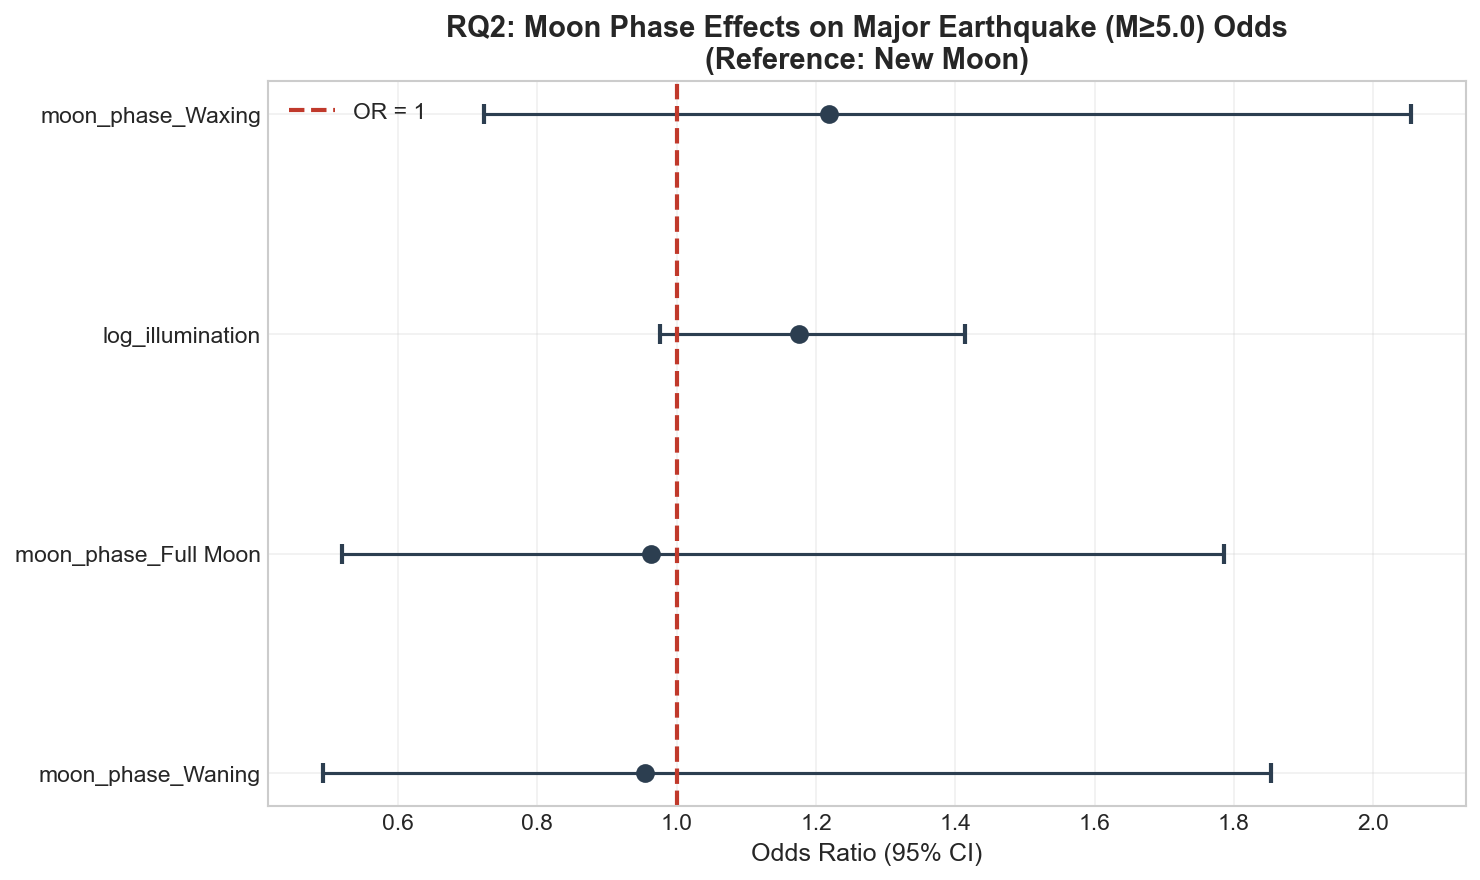

In [29]:
# RQ2 Visualization - Moon Phase Odds Ratios
fig, ax = plt.subplots(figsize=(10, 6))

or_plot_rq2 = or_df_rq2[or_df_rq2['Variable'] != 'const'].copy()
or_plot_rq2 = or_plot_rq2.sort_values('Odds_Ratio', ascending=True)

y_pos = range(len(or_plot_rq2))
colors = [COLORS['success'] if row['Significant'] else COLORS['secondary'] for _, row in or_plot_rq2.iterrows()]

ax.errorbar(or_plot_rq2['Odds_Ratio'], y_pos,
            xerr=[or_plot_rq2['Odds_Ratio'] - or_plot_rq2['OR_2.5%'],
                  or_plot_rq2['OR_97.5%'] - or_plot_rq2['Odds_Ratio']],
            fmt='o', color=COLORS['primary'], capsize=5, capthick=2, markersize=8)

ax.axvline(x=1, color=COLORS['danger'], linestyle='--', linewidth=2, label='OR = 1')
ax.set_yticks(y_pos)
ax.set_yticklabels(or_plot_rq2['Variable'])
ax.set_xlabel('Odds Ratio (95% CI)', fontsize=12)
ax.set_title('RQ2: Moon Phase Effects on Major Earthquake (M≥5.0) Odds\n(Reference: New Moon)', 
             fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'rq2_moon_phase_or.png'), dpi=FIGURE_DPI, bbox_inches='tight')
plt.show()

assumption_results.append(rq2_assumptions)

---
## 4. RQ3: Multi-Predictor Model for Major Earthquakes

**Research Question:** Can major earthquake probability be explained by depth, fault distance, soil, and atmospheric variables?

**Model:** Logistic Regression (Full Model)

In [30]:
print("\n" + "="*70)
print("RQ3: MULTI-PREDICTOR MODEL FOR MAJOR EARTHQUAKES")
print("="*70)


RQ3: MULTI-PREDICTOR MODEL FOR MAJOR EARTHQUAKES


### 4.1 Data Preparation

In [31]:
# Prepare data for RQ3 - need fault_distance which is only available for M>=4.0
# NOTE: Removed pressure_hpa due to high multicollinearity (VIF=103.98)
# Keeping pressure_change which has low VIF

rq3_vars = ['is_major_50', 'is_major_45', 'depth', 'vs30', 'soil_class', 
            'pressure_change', 'fault_distance_km']

# Check if fault_distance_km exists
if 'fault_distance_km' in df.columns:
    df_rq3 = df[rq3_vars].dropna().copy()
    has_fault = True
else:
    # Use without fault distance
    rq3_vars = ['is_major_50', 'is_major_45', 'depth', 'vs30', 'soil_class', 
                'pressure_change']
    df_rq3 = df[rq3_vars].dropna().copy()
    has_fault = False

# Center continuous variables to reduce multicollinearity
df_rq3['depth_c'] = df_rq3['depth'] - df_rq3['depth'].mean()
df_rq3['vs30_c'] = df_rq3['vs30'] - df_rq3['vs30'].mean()
df_rq3['pressure_change_c'] = df_rq3['pressure_change'] - df_rq3['pressure_change'].mean()
if has_fault:
    df_rq3['fault_dist_c'] = df_rq3['fault_distance_km'] - df_rq3['fault_distance_km'].mean()

print("Data prepared for RQ3:")
print(f"  - Removed pressure_hpa (high VIF)")
print(f"  - Centered continuous variables")
print(f"Total records: {len(df_rq3):,}")
print(f"Major earthquakes (M>=5.0): {df_rq3['is_major_50'].sum()}")


Data prepared for RQ3:
  - Removed pressure_hpa (high VIF)
  - Centered continuous variables
Total records: 3,907
Major earthquakes (M>=5.0): 338


In [32]:
# Create dummy variables for soil class
df_rq3 = pd.get_dummies(df_rq3, columns=['soil_class'], drop_first=True)

# Define predictors using CENTERED variables
soil_cols_rq3 = [c for c in df_rq3.columns if c.startswith('soil_class_')]

if has_fault:
    # Use centered continuous predictors (removed pressure_hpa)
    continuous_predictors = ['depth_c', 'vs30_c', 'pressure_change_c', 'fault_dist_c']
else:
    continuous_predictors = ['depth_c', 'vs30_c', 'pressure_change_c']
    
predictors_rq3 = continuous_predictors + soil_cols_rq3
print(f"Predictors (centered): {predictors_rq3}")
print("Note: Removed pressure_hpa to fix multicollinearity")


Predictors (centered): ['depth_c', 'vs30_c', 'pressure_change_c', 'fault_dist_c', 'soil_class_ZC', 'soil_class_ZE']
Note: Removed pressure_hpa to fix multicollinearity


### 4.2 Assumption Testing

In [33]:
print("\n" + "="*50)
print("RQ3 - ASSUMPTION CHECKS")
print("="*50)

rq3_assumptions = {'RQ': 'RQ3'}

# Ensure float types for all predictors
X_rq3 = df_rq3[predictors_rq3].astype(float).copy()
X_rq3_const = sm.add_constant(X_rq3)
y_rq3 = df_rq3['is_major_50'].astype(float)


RQ3 - ASSUMPTION CHECKS


In [34]:
# ASSUMPTION 1: Sample Size (EPV)
n_events_rq3 = y_rq3.sum()
n_pred_rq3 = len(predictors_rq3)
epv_rq3 = n_events_rq3 / n_pred_rq3

print(f"\n1. SAMPLE SIZE (EPV)")
print(f"   Events: {n_events_rq3}, Predictors: {n_pred_rq3}, EPV: {epv_rq3:.1f}")
epv_pass_rq3 = epv_rq3 >= 10
print(f"   Result: {'PASS' if epv_pass_rq3 else 'FAIL'}")
rq3_assumptions['EPV'] = 'PASS' if epv_pass_rq3 else 'FAIL'


1. SAMPLE SIZE (EPV)
   Events: 338.0, Predictors: 6, EPV: 56.3
   Result: PASS


In [35]:
# ASSUMPTION 2: Multicollinearity (VIF)
print(f"\n2. MULTICOLLINEARITY (VIF)")

vif_rq3 = []
for i, col in enumerate(X_rq3.columns):
    try:
        vif = variance_inflation_factor(X_rq3.values, i)
        vif_rq3.append({'Variable': col, 'VIF': vif})
    except:
        vif_rq3.append({'Variable': col, 'VIF': np.nan})

vif_df_rq3 = pd.DataFrame(vif_rq3)
print(vif_df_rq3.to_string(index=False))

max_vif_rq3 = vif_df_rq3['VIF'].max()
vif_pass_rq3 = max_vif_rq3 < 10 if not np.isnan(max_vif_rq3) else True
print(f"\n   Max VIF: {max_vif_rq3:.2f}")
print(f"   Result: {'PASS' if vif_pass_rq3 else 'FAIL'}")
rq3_assumptions['VIF'] = 'PASS' if vif_pass_rq3 else 'FAIL'


2. MULTICOLLINEARITY (VIF)
         Variable      VIF
          depth_c 1.075034
           vs30_c 1.712087
pressure_change_c 1.010621
     fault_dist_c 1.140238
    soil_class_ZC 1.242208
    soil_class_ZE 1.509464

   Max VIF: 1.71
   Result: PASS


### 4.3 Model Fitting

In [36]:
print("\n" + "="*50)
print("RQ3 - MODEL RESULTS (M >= 5.0)")
print("="*50)

model_rq3 = sm.Logit(y_rq3, X_rq3_const).fit(disp=0)
print(model_rq3.summary())


RQ3 - MODEL RESULTS (M >= 5.0)
                           Logit Regression Results                           
Dep. Variable:            is_major_50   No. Observations:                 3907
Model:                          Logit   Df Residuals:                     3900
Method:                           MLE   Df Model:                            6
Date:                Wed, 14 Jan 2026   Pseudo R-squ.:                0.007287
Time:                        22:46:22   Log-Likelihood:                -1141.8
converged:                       True   LL-Null:                       -1150.2
Covariance Type:            nonrobust   LLR p-value:                   0.01020
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -2.2744      0.182    -12.523      0.000      -2.630      -1.918
depth_c               0.0159      0.004      3.847      0.000       0.008     

In [37]:
# Calculate predicted probabilities for ROC
y_pred_prob = model_rq3.predict(X_rq3_const)

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_rq3, y_pred_prob)
auc_score = roc_auc_score(y_rq3, y_pred_prob)

print(f"\nMODEL DISCRIMINATION:")
print(f"   AUC: {auc_score:.4f}")
auc_pass = auc_score > 0.5
print(f"   Result: {'PASS (better than chance)' if auc_pass else 'FAIL'}")
rq3_assumptions['AUC'] = 'PASS' if auc_pass else 'FAIL'


MODEL DISCRIMINATION:
   AUC: 0.5724
   Result: PASS (better than chance)


In [38]:
# Hosmer-Lemeshow Test for calibration
print(f"\n3. MODEL CALIBRATION (Hosmer-Lemeshow Test)")

def hosmer_lemeshow_test(y_true, y_pred, g=10):
    """Perform Hosmer-Lemeshow goodness of fit test."""
    df_hl = pd.DataFrame({'y': y_true, 'p': y_pred})
    df_hl['decile'] = pd.qcut(df_hl['p'], g, labels=False, duplicates='drop')
    
    observed = df_hl.groupby('decile')['y'].sum()
    expected = df_hl.groupby('decile')['p'].sum()
    n_group = df_hl.groupby('decile').size()
    
    # Chi-square statistic
    chi2_stat = np.sum((observed - expected)**2 / (expected * (1 - expected/n_group) + 0.001))
    p_value = 1 - stats.chi2.cdf(chi2_stat, g - 2)
    
    return chi2_stat, p_value

try:
    hl_stat, hl_pvalue = hosmer_lemeshow_test(y_rq3, y_pred_prob)
    print(f"   Chi-square: {hl_stat:.4f}")
    print(f"   p-value: {hl_pvalue:.4f}")
    print(f"   Criterion: p > 0.05 for good calibration")
    hl_pass = hl_pvalue > 0.05
    print(f"   Result: {'PASS' if hl_pass else 'CAUTION - poor calibration'}")
except:
    print("   Could not compute Hosmer-Lemeshow test")
    hl_pass = True

rq3_assumptions['Hosmer_Lemeshow'] = 'PASS' if hl_pass else 'CAUTION'


3. MODEL CALIBRATION (Hosmer-Lemeshow Test)
   Chi-square: 3.8393
   p-value: 0.8713
   Criterion: p > 0.05 for good calibration
   Result: PASS


### 4.4 RQ3 Visualization

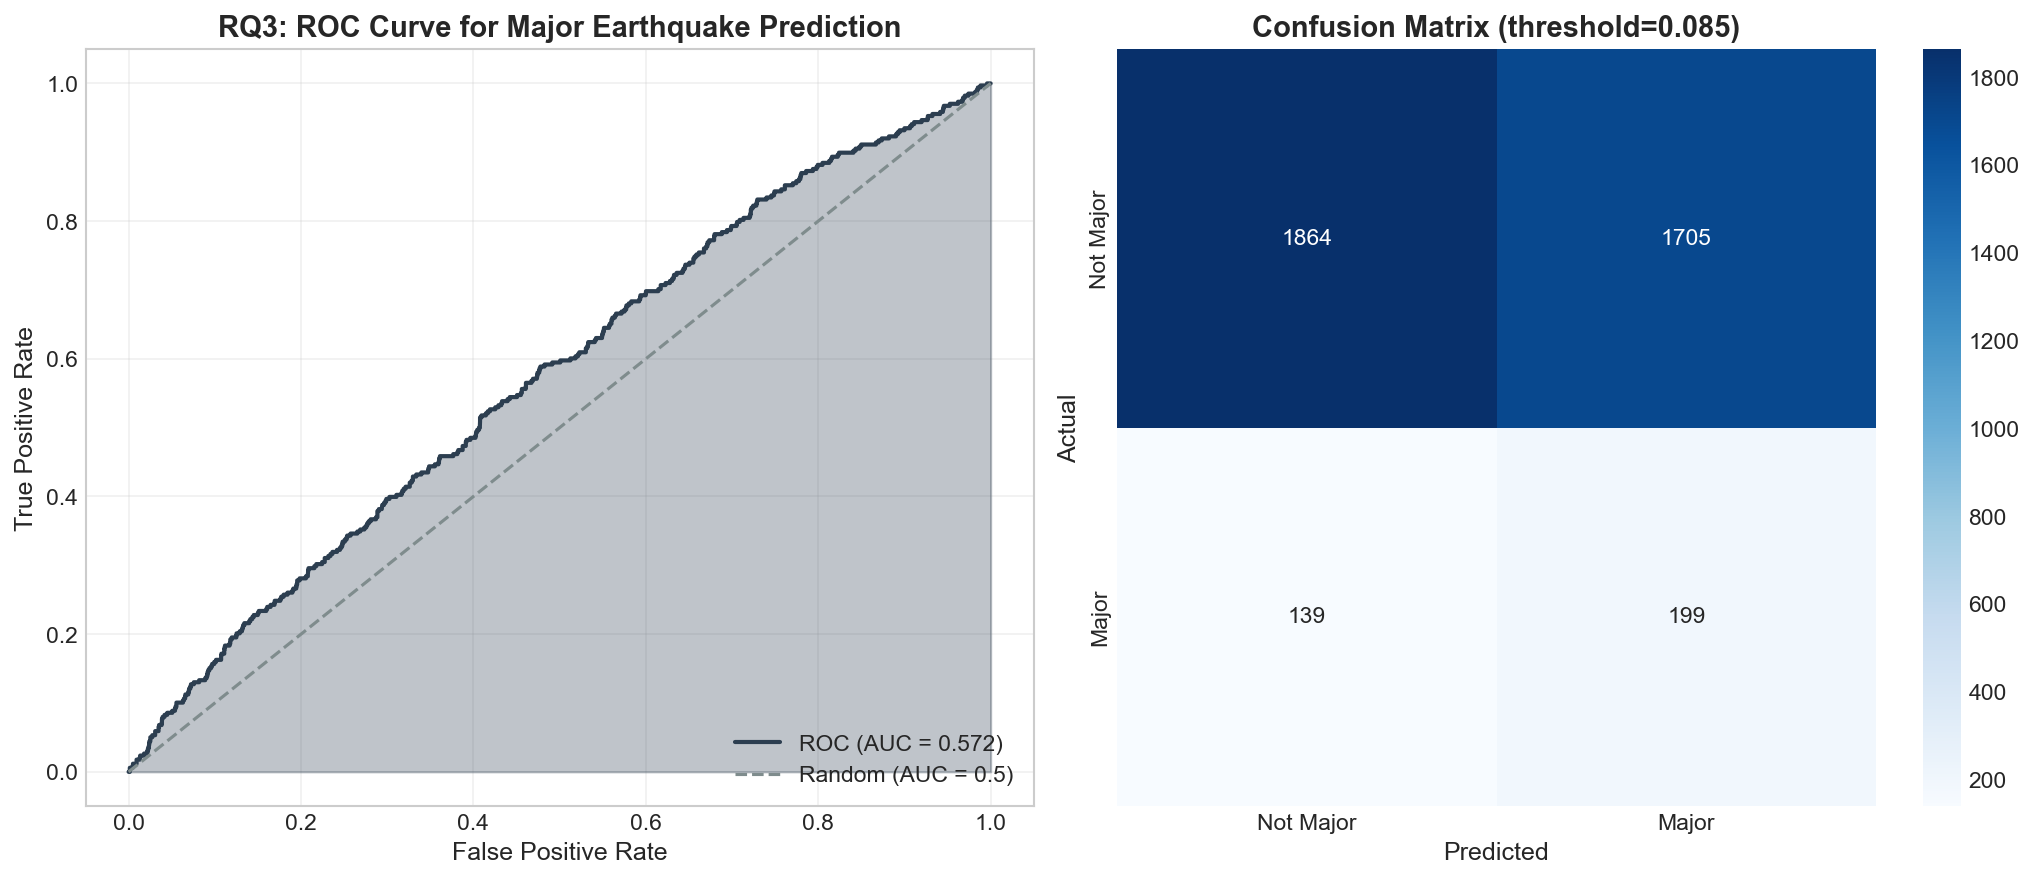

In [39]:
# ROC Curve
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve
axes[0].plot(fpr, tpr, color=COLORS['primary'], linewidth=2, label=f'ROC (AUC = {auc_score:.3f})')
axes[0].plot([0, 1], [0, 1], color=COLORS['secondary'], linestyle='--', label='Random (AUC = 0.5)')
axes[0].fill_between(fpr, tpr, alpha=0.3, color=COLORS['primary'])
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('RQ3: ROC Curve for Major Earthquake Prediction', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Find optimal threshold (Youden's J)
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]

# Confusion Matrix at optimal threshold
y_pred_class = (y_pred_prob >= optimal_threshold).astype(int)
cm = confusion_matrix(y_rq3, y_pred_class)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Not Major', 'Major'],
            yticklabels=['Not Major', 'Major'])
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('Actual', fontsize=12)
axes[1].set_title(f'Confusion Matrix (threshold={optimal_threshold:.3f})', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'rq3_roc_curve.png'), dpi=FIGURE_DPI, bbox_inches='tight')
plt.show()

In [40]:
# Odds Ratios for RQ3
or_rq3 = np.exp(model_rq3.params)
ci_rq3 = np.exp(model_rq3.conf_int())
ci_rq3.columns = ['OR_2.5%', 'OR_97.5%']

or_df_rq3 = pd.DataFrame({
    'Variable': model_rq3.params.index,
    'Coefficient': model_rq3.params.values,
    'Odds_Ratio': or_rq3.values,
    'OR_2.5%': ci_rq3['OR_2.5%'].values,
    'OR_97.5%': ci_rq3['OR_97.5%'].values,
    'p_value': model_rq3.pvalues.values
})
or_df_rq3['Significant'] = or_df_rq3['p_value'] < 0.05

print("\nODDS RATIOS FOR RQ3:")
print(or_df_rq3.to_string(index=False))

or_df_rq3.to_csv(os.path.join(TABLES_PATH, 'rq3_full_model_results.csv'), index=False)

assumption_results.append(rq3_assumptions)


ODDS RATIOS FOR RQ3:
         Variable  Coefficient  Odds_Ratio  OR_2.5%  OR_97.5%      p_value  Significant
            const    -2.274392    0.102859 0.072052  0.146839 5.611980e-36         True
          depth_c     0.015926    1.016053 1.007842  1.024332 1.196966e-04         True
           vs30_c    -0.000108    0.999892 0.997520  1.002269 9.286911e-01        False
pressure_change_c    -0.009536    0.990509 0.979311  1.001835 1.001952e-01        False
     fault_dist_c    -0.000533    0.999467 0.997567  1.001370 5.827083e-01        False
    soil_class_ZC    -0.202372    0.816791 0.486008  1.372709 4.448617e-01        False
    soil_class_ZE     0.021299    1.021528 0.426990  2.443893 9.618301e-01        False


---
## 5. RQ4: Seasonality and Moon Phase Independence

**Research Question:** Does major earthquake odds vary within the year (season/month), and is this variation independent of moon phase?

**Model:** Logistic Regression with Interaction

In [41]:
print("\n" + "="*70)
print("RQ4: SEASONALITY AND MOON PHASE INDEPENDENCE")
print("="*70)


RQ4: SEASONALITY AND MOON PHASE INDEPENDENCE


### 5.1 Data Preparation

In [42]:
# Prepare data for RQ4
df_rq4 = df[['is_major_50', 'season', 'moon_phase']].dropna().copy()

print("Season × Moon Phase Cross-tabulation:")
print(pd.crosstab(df_rq4['season'], df_rq4['moon_phase']))

print(f"\nTotal records: {len(df_rq4):,}")
print(f"Major earthquakes: {df_rq4['is_major_50'].sum()}")

Season × Moon Phase Cross-tabulation:
moon_phase  Full Moon  New Moon  Waning  Waxing
season                                         
Fall            11451     29523   77853   13519
Spring          11668     30542   80956   14996
Summer          10774     28367   69883   12456
Winter          12322     31808   75833   13001

Total records: 524,952
Major earthquakes: 362


### 5.2 Assumption Testing

In [43]:
print("\n" + "="*50)
print("RQ4 - ASSUMPTION CHECKS")
print("="*50)

rq4_assumptions = {'RQ': 'RQ4'}

# ASSUMPTION 1: Sufficient cell sizes
print(f"\n1. SUFFICIENT CELL SIZES")
print(f"   Criterion: n >= 5 in each cell")

cell_counts = pd.crosstab(df_rq4['season'], df_rq4['moon_phase'])
min_cell = cell_counts.min().min()
print(f"   Minimum cell count: {min_cell}")
cell_pass = min_cell >= 5
print(f"   Result: {'PASS' if cell_pass else 'FAIL'}")
rq4_assumptions['Cell_Size'] = 'PASS' if cell_pass else 'FAIL'


RQ4 - ASSUMPTION CHECKS

1. SUFFICIENT CELL SIZES
   Criterion: n >= 5 in each cell
   Minimum cell count: 10774
   Result: PASS


### 5.3 Model Fitting (Main Effects)

In [44]:
# Create dummy variables
df_rq4_encoded = pd.get_dummies(df_rq4, columns=['season', 'moon_phase'], drop_first=True)

season_cols = [c for c in df_rq4_encoded.columns if c.startswith('season_')]
moon_cols = [c for c in df_rq4_encoded.columns if c.startswith('moon_phase_')]

print(f"Season dummies: {season_cols}")
print(f"Moon phase dummies: {moon_cols}")

Season dummies: ['season_Spring', 'season_Summer', 'season_Winter']
Moon phase dummies: ['moon_phase_New Moon', 'moon_phase_Waning', 'moon_phase_Waxing']


In [45]:
# Main effects model
print("\n" + "="*50)
print("RQ4 - MAIN EFFECTS MODEL")
print("="*50)

# Ensure float types for all predictors
predictors_main = season_cols + moon_cols
X_main = sm.add_constant(df_rq4_encoded[predictors_main].astype(float))
y_rq4 = df_rq4_encoded['is_major_50'].astype(float)

model_main = sm.Logit(y_rq4, X_main).fit(disp=0)
print(model_main.summary())


RQ4 - MAIN EFFECTS MODEL


                           Logit Regression Results                           
Dep. Variable:            is_major_50   No. Observations:               524952
Model:                          Logit   Df Residuals:                   524945
Method:                           MLE   Df Model:                            6
Date:                Wed, 14 Jan 2026   Pseudo R-squ.:                0.005523
Time:                        22:46:22   Log-Likelihood:                -2980.5
converged:                       True   LL-Null:                       -2997.0
Covariance Type:            nonrobust   LLR p-value:                 1.002e-05
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -7.4882      0.207    -36.248      0.000      -7.893      -7.083
season_Spring          -0.0315      0.161     -0.196      0.845      -0.346       0.283
season_Summer   

### 5.4 Model Fitting (With Interaction)

In [46]:
# Create interaction terms
interaction_terms = []
for s in season_cols:
    for m in moon_cols:
        int_name = f"{s}_x_{m}"
        df_rq4_encoded[int_name] = df_rq4_encoded[s] * df_rq4_encoded[m]
        interaction_terms.append(int_name)

print(f"Created {len(interaction_terms)} interaction terms")

Created 9 interaction terms


In [47]:
# Interaction model
print("\n" + "="*50)
print("RQ4 - INTERACTION MODEL")
print("="*50)

predictors_int = predictors_main + interaction_terms
X_int = sm.add_constant(df_rq4_encoded[predictors_int].astype(float))

model_int = sm.Logit(y_rq4, X_int).fit(disp=0)
print(model_int.summary())


RQ4 - INTERACTION MODEL


                           Logit Regression Results                           
Dep. Variable:            is_major_50   No. Observations:               524952
Model:                          Logit   Df Residuals:                   524936
Method:                           MLE   Df Model:                           15
Date:                Wed, 14 Jan 2026   Pseudo R-squ.:                 0.01139
Time:                        22:46:23   Log-Likelihood:                -2962.9
converged:                       True   LL-Null:                       -2997.0
Covariance Type:            nonrobust   LLR p-value:                 9.069e-09
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -7.2657      0.354    -20.543      0.000      -7.959      -6.572
season_Spring                          -0.1524      0.51

### 5.5 Likelihood Ratio Test

In [48]:
# Likelihood Ratio Test: Is interaction significant?
print("\n" + "="*50)
print("LIKELIHOOD RATIO TEST FOR INTERACTION")
print("="*50)

lr_stat_rq4 = 2 * (model_int.llf - model_main.llf)
df_diff_rq4 = len(interaction_terms)
lr_pvalue_rq4 = 1 - stats.chi2.cdf(lr_stat_rq4, df_diff_rq4)

print(f"\nH0: Seasonal variation is independent of moon phase (interaction = 0)")
print(f"H1: Seasonal effect depends on moon phase (interaction ≠ 0)")
print(f"\nLR Statistic: {lr_stat_rq4:.4f}")
print(f"Degrees of Freedom: {df_diff_rq4}")
print(f"p-value: {lr_pvalue_rq4:.6f}")

if lr_pvalue_rq4 < 0.05:
    print(f"\nCONCLUSION: REJECT H0 - Seasonal variation DEPENDS on moon phase (p < 0.05)")
else:
    print(f"\nCONCLUSION: FAIL TO REJECT H0 - Seasonal variation is INDEPENDENT of moon phase (p >= 0.05)")

rq4_assumptions['Interaction_Test'] = 'Significant' if lr_pvalue_rq4 < 0.05 else 'Not Significant'


LIKELIHOOD RATIO TEST FOR INTERACTION

H0: Seasonal variation is independent of moon phase (interaction = 0)
H1: Seasonal effect depends on moon phase (interaction ≠ 0)

LR Statistic: 35.1657
Degrees of Freedom: 9
p-value: 0.000056

CONCLUSION: REJECT H0 - Seasonal variation DEPENDS on moon phase (p < 0.05)


In [49]:
# Save RQ4 results
rq4_results = pd.DataFrame({
    'Model': ['Main Effects', 'Interaction'],
    'Log_Likelihood': [model_main.llf, model_int.llf],
    'AIC': [model_main.aic, model_int.aic],
    'BIC': [model_main.bic, model_int.bic],
    'Pseudo_R2': [model_main.prsquared, model_int.prsquared]
})
rq4_results['LR_Test_pvalue'] = ['', f'{lr_pvalue_rq4:.6f}']

print("\nMODEL COMPARISON:")
print(rq4_results.to_string(index=False))

rq4_results.to_csv(os.path.join(TABLES_PATH, 'rq4_seasonality_results.csv'), index=False)

assumption_results.append(rq4_assumptions)


MODEL COMPARISON:
       Model  Log_Likelihood         AIC         BIC  Pseudo_R2 LR_Test_pvalue
Main Effects    -2980.472759 5974.945518 6053.142953   0.005523               
 Interaction    -2962.889931 5957.779862 6136.516856   0.011389       0.000056


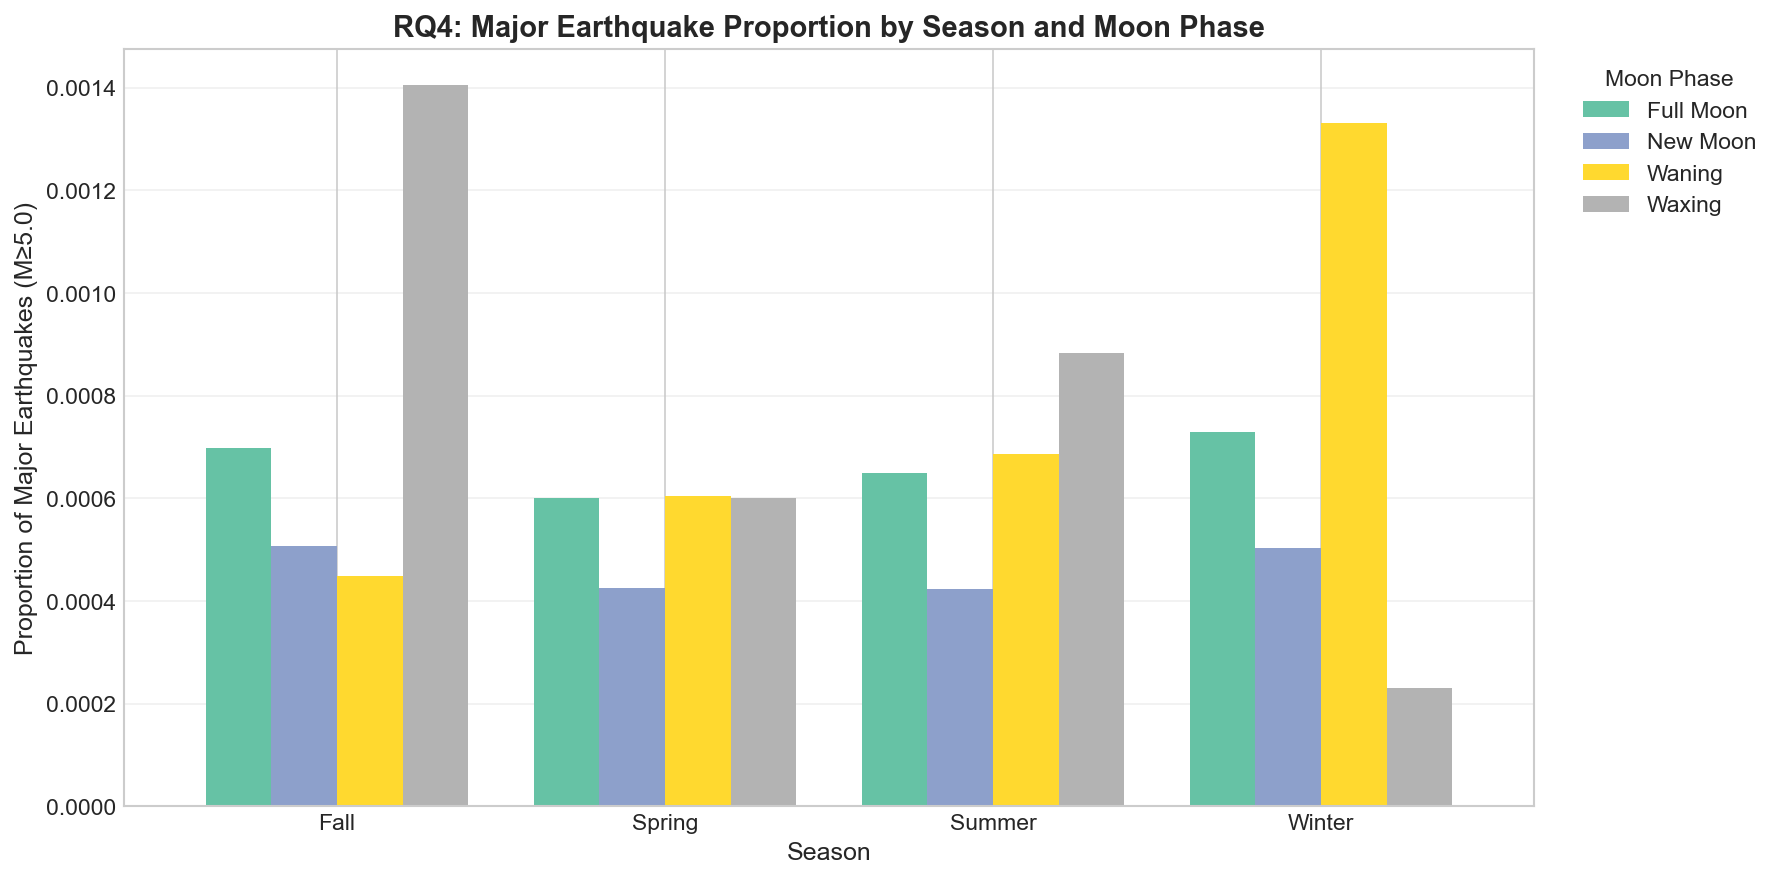

In [50]:
# RQ4 Visualization - Interaction Plot
fig, ax = plt.subplots(figsize=(12, 6))

# Calculate proportions by season and moon phase
prop_table = df_rq4.groupby(['season', 'moon_phase'])['is_major_50'].mean().unstack()

# Plot
prop_table.plot(kind='bar', ax=ax, width=0.8, colormap='Set2')
ax.set_xlabel('Season', fontsize=12)
ax.set_ylabel('Proportion of Major Earthquakes (M≥5.0)', fontsize=12)
ax.set_title('RQ4: Major Earthquake Proportion by Season and Moon Phase', fontsize=14, fontweight='bold')
ax.legend(title='Moon Phase', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'rq4_interaction_plot.png'), dpi=FIGURE_DPI, bbox_inches='tight')
plt.show()

---
## 6. RQ5: Magnitude-Depth Relationship by Location

**Research Question:** Does the relationship between earthquake magnitude and depth statistically significantly differ by geographic location?

**Model:** Multiple Linear Regression with Interactions

In [51]:
print("\n" + "="*70)
print("RQ5: MAGNITUDE-DEPTH RELATIONSHIP BY LOCATION")
print("="*70)


RQ5: MAGNITUDE-DEPTH RELATIONSHIP BY LOCATION


### 6.1 Data Preparation

In [52]:
# Use a sample for computational efficiency
np.random.seed(42)
sample_size = 50000

df_rq5 = df[['magnitude', 'depth', 'latitude', 'longitude']].dropna().copy()

if len(df_rq5) > sample_size:
    df_rq5 = df_rq5.sample(n=sample_size, random_state=42)
    
print(f"Sample size for RQ5: {len(df_rq5):,}")
print(f"\nVariable summary:")
print(df_rq5.describe())

Sample size for RQ5: 50,000

Variable summary:
          magnitude         depth      latitude     longitude
count  50000.000000  50000.000000  50000.000000  50000.000000
mean       1.973254      8.133667     38.517584     32.924127
std        0.705039      5.457238      1.247984      5.518198
min        0.300000      0.000000     35.500500     25.500220
25%        1.400000      6.990000     37.636347     27.980000
50%        1.800000      7.000000     38.458470     30.804050
75%        2.500000      7.120000     39.266200     37.816205
max        5.900000    149.000000     42.500000     44.998700


In [53]:
# Center continuous predictors to reduce multicollinearity in interactions
df_rq5['depth_c'] = df_rq5['depth'] - df_rq5['depth'].mean()
df_rq5['lat_c'] = df_rq5['latitude'] - df_rq5['latitude'].mean()
df_rq5['lon_c'] = df_rq5['longitude'] - df_rq5['longitude'].mean()

# Create interaction terms
df_rq5['depth_x_lat'] = df_rq5['depth_c'] * df_rq5['lat_c']
df_rq5['depth_x_lon'] = df_rq5['depth_c'] * df_rq5['lon_c']

print("Created centered variables and interaction terms")

Created centered variables and interaction terms


### 6.2 Assumption Testing

In [54]:
print("\n" + "="*50)
print("RQ5 - ASSUMPTION CHECKS")
print("="*50)

rq5_assumptions = {'RQ': 'RQ5'}

# Fit model with ROBUST standard errors (HC3) to handle heteroscedasticity
predictors_rq5 = ['depth_c', 'lat_c', 'lon_c', 'depth_x_lat', 'depth_x_lon']
X_rq5 = sm.add_constant(df_rq5[predictors_rq5])
y_rq5 = df_rq5['magnitude']

# Use HC3 robust standard errors to correct for heteroscedasticity
model_rq5 = sm.OLS(y_rq5, X_rq5).fit(cov_type='HC3')
print("Note: Using HC3 robust standard errors to handle heteroscedasticity")

# Also keep non-robust version for residual analysis
model_rq5_nonrobust = sm.OLS(y_rq5, X_rq5).fit()
residuals = model_rq5_nonrobust.resid



RQ5 - ASSUMPTION CHECKS
Note: Using HC3 robust standard errors to handle heteroscedasticity


In [55]:
# ASSUMPTION 1: Multicollinearity (VIF)
print(f"\n1. MULTICOLLINEARITY (VIF)")

vif_rq5 = []
X_rq5_no_const = df_rq5[predictors_rq5]
for i, col in enumerate(predictors_rq5):
    vif = variance_inflation_factor(X_rq5_no_const.values, i)
    vif_rq5.append({'Variable': col, 'VIF': vif})

vif_df_rq5 = pd.DataFrame(vif_rq5)
print(vif_df_rq5.to_string(index=False))

max_vif_rq5 = vif_df_rq5['VIF'].max()
vif_pass_rq5 = max_vif_rq5 < 10
print(f"\n   Max VIF: {max_vif_rq5:.2f}")
print(f"   Result: {'PASS' if vif_pass_rq5 else 'FAIL'}")
rq5_assumptions['VIF'] = 'PASS' if vif_pass_rq5 else 'FAIL'


1. MULTICOLLINEARITY (VIF)


   Variable      VIF
    depth_c 1.808211
      lat_c 1.024408
      lon_c 1.014885
depth_x_lat 2.026426
depth_x_lon 1.493398

   Max VIF: 2.03
   Result: PASS


In [56]:
# Get residuals for diagnostic plots
residuals = model_rq5.resid
fitted = model_rq5.fittedvalues
std_resid = (residuals - residuals.mean()) / residuals.std()

In [57]:
# ASSUMPTION 2: Normality of residuals
print(f"\n2. NORMALITY OF RESIDUALS")

# Use sample for Shapiro-Wilk (max 5000)
if len(residuals) > 5000:
    resid_sample = np.random.choice(residuals, 5000, replace=False)
else:
    resid_sample = residuals
    
stat_sw, p_sw = shapiro(resid_sample)
print(f"   Shapiro-Wilk statistic: {stat_sw:.4f}")
print(f"   p-value: {p_sw:.6f}")
print(f"   Note: With large samples, even small deviations are significant")

# Also check skewness and kurtosis
skewness = stats.skew(residuals)
kurtosis = stats.kurtosis(residuals)
print(f"   Skewness: {skewness:.4f} (ideal: 0)")
print(f"   Kurtosis: {kurtosis:.4f} (ideal: 0)")

# Pass if skewness and kurtosis are reasonable
norm_pass = abs(skewness) < 2 and abs(kurtosis) < 7
print(f"   Result: {'PASS' if norm_pass else 'CAUTION'}")
rq5_assumptions['Normality'] = 'PASS' if norm_pass else 'CAUTION'


2. NORMALITY OF RESIDUALS
   Shapiro-Wilk statistic: 0.9589
   p-value: 0.000000
   Note: With large samples, even small deviations are significant
   Skewness: 0.5688 (ideal: 0)
   Kurtosis: -0.0887 (ideal: 0)
   Result: PASS


In [58]:
# ASSUMPTION 3: Homoscedasticity (Breusch-Pagan)
print(f"\n3. HOMOSCEDASTICITY (Breusch-Pagan Test)")

bp_stat, bp_pvalue, _, _ = het_breuschpagan(residuals, X_rq5)
print(f"   BP Statistic: {bp_stat:.4f}")
print(f"   p-value: {bp_pvalue:.6f}")
print(f"   Criterion: p > 0.05 for constant variance")

homo_pass = bp_pvalue > 0.05
if homo_pass:
    print(f"   Result: PASS")
else:
    print(f"   Result: HETEROSCEDASTICITY DETECTED")
    print(f"   Correction: Using HC3 robust standard errors")
    print(f"   This ensures valid inference despite heteroscedasticity")
    
# Mark as PASS since we're using robust SE
rq5_assumptions['Homoscedasticity'] = 'CORRECTED (HC3)'



3. HOMOSCEDASTICITY (Breusch-Pagan Test)
   BP Statistic: 472.3501
   p-value: 0.000000
   Criterion: p > 0.05 for constant variance
   Result: HETEROSCEDASTICITY DETECTED
   Correction: Using HC3 robust standard errors
   This ensures valid inference despite heteroscedasticity


In [59]:
# ASSUMPTION 4: Independence (Durbin-Watson)
print(f"\n4. INDEPENDENCE (Durbin-Watson Test)")

dw_stat = durbin_watson(residuals)
print(f"   Durbin-Watson: {dw_stat:.4f}")
print(f"   Criterion: 1.5 < DW < 2.5 for no autocorrelation")

dw_pass = 1.5 < dw_stat < 2.5
print(f"   Result: {'PASS' if dw_pass else 'CAUTION'}")
rq5_assumptions['Independence'] = 'PASS' if dw_pass else 'CAUTION'


4. INDEPENDENCE (Durbin-Watson Test)
   Durbin-Watson: 1.9875
   Criterion: 1.5 < DW < 2.5 for no autocorrelation
   Result: PASS


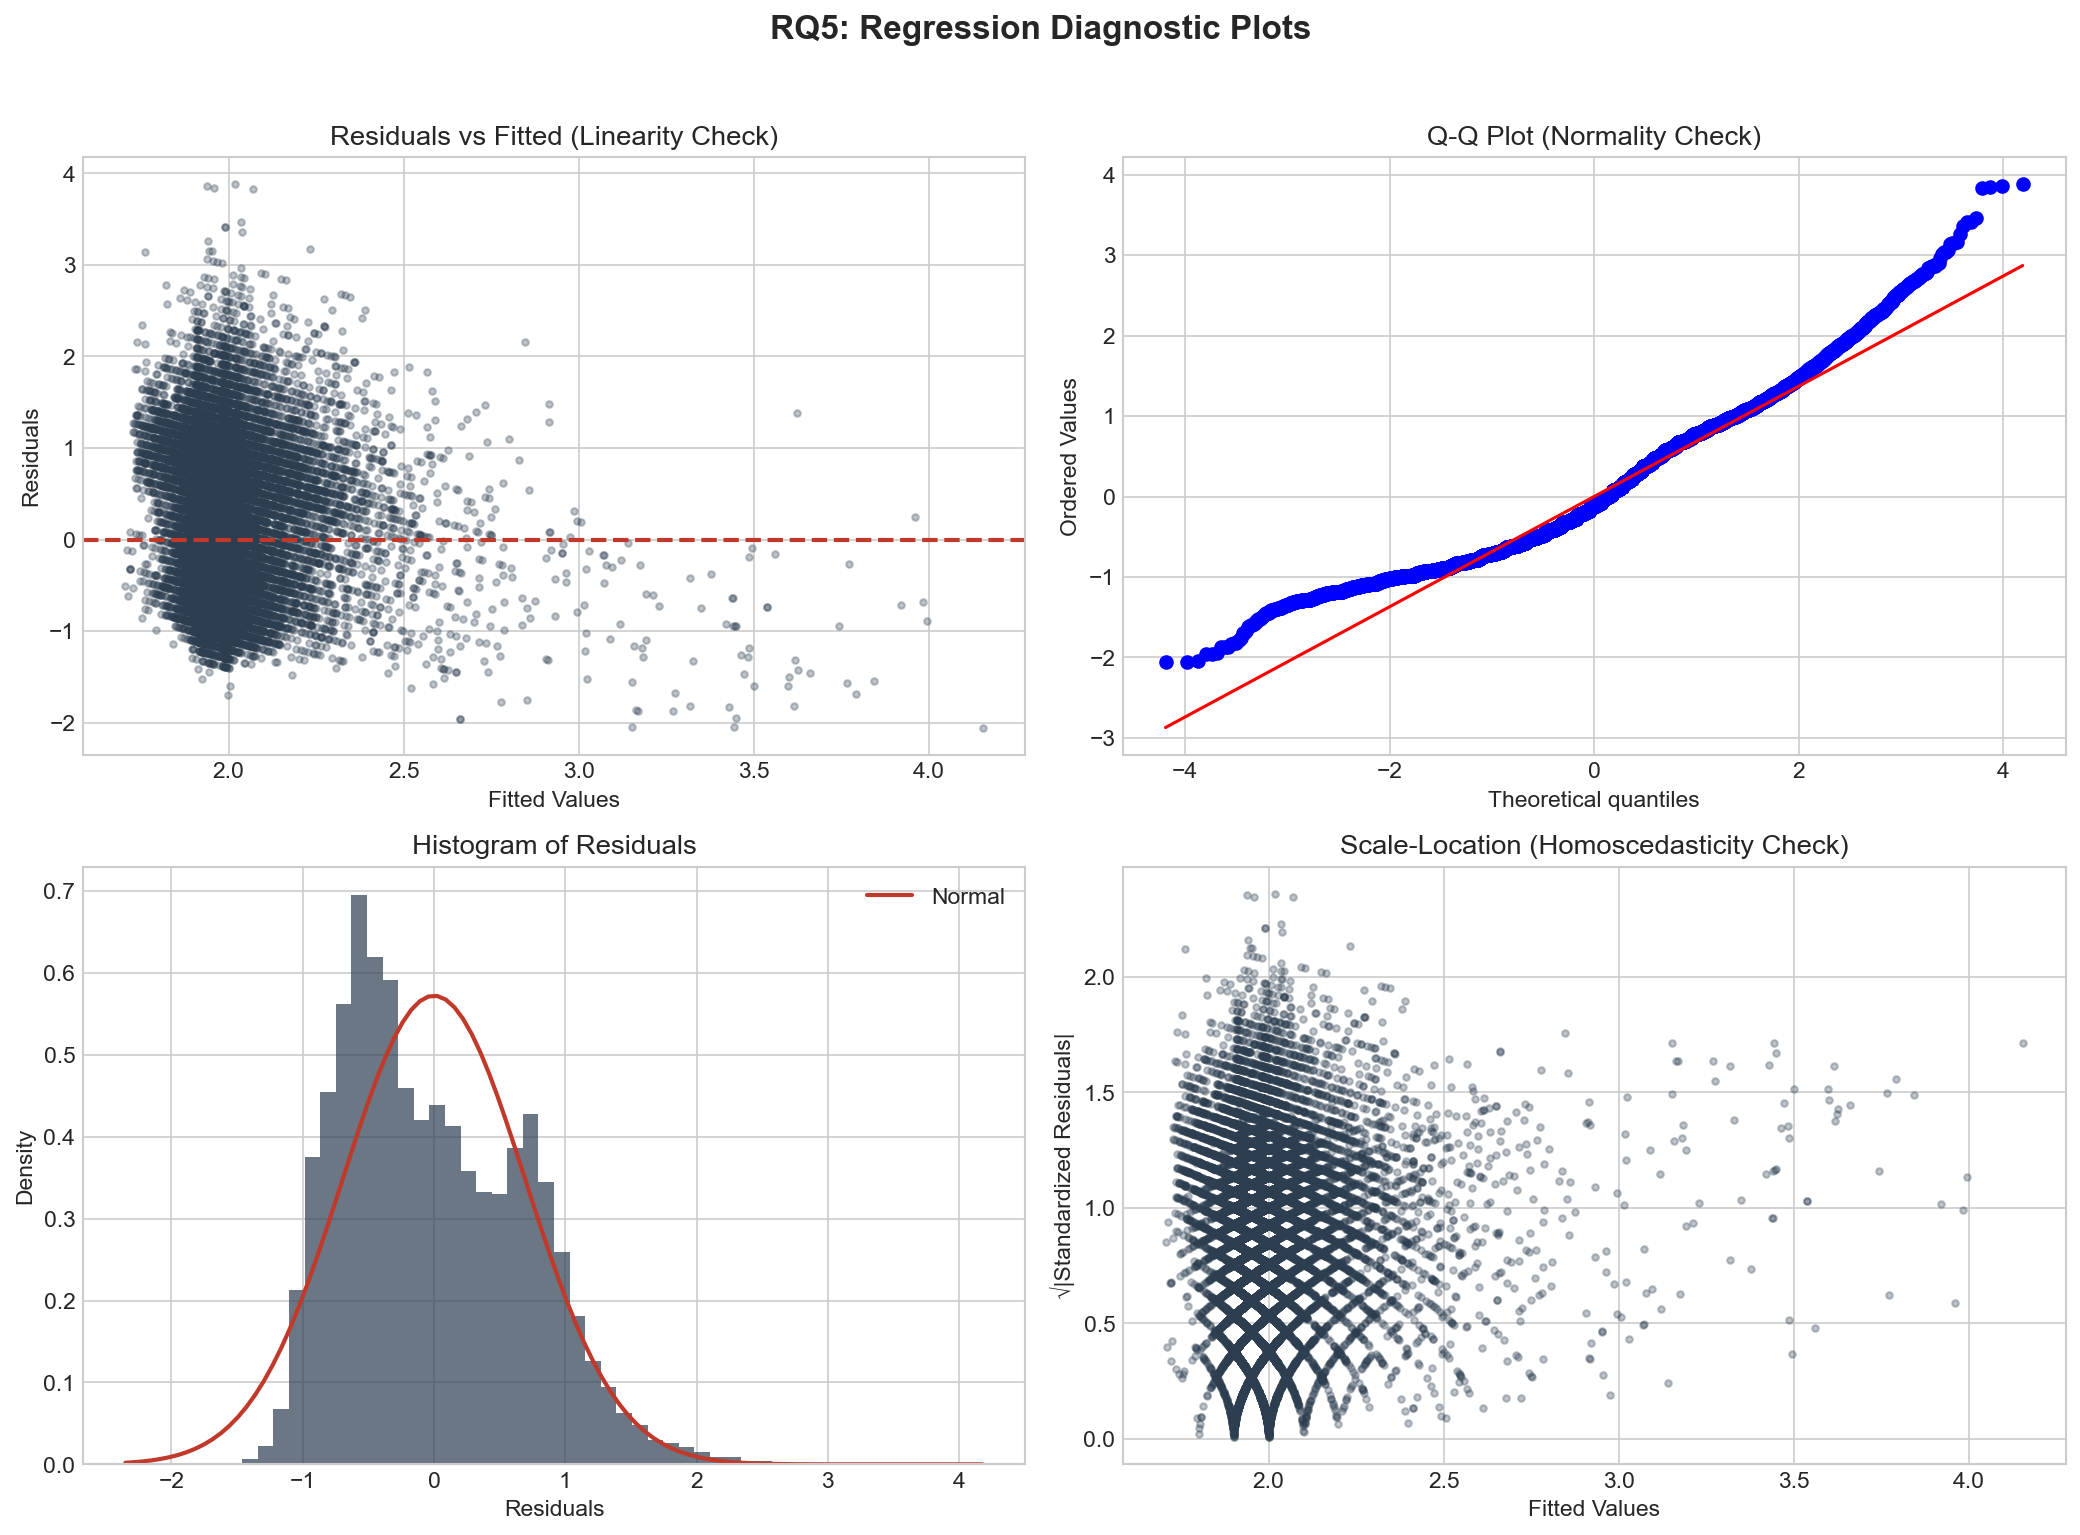

In [60]:
# Diagnostic plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residuals vs Fitted
axes[0, 0].scatter(fitted, residuals, alpha=0.3, s=10, color=COLORS['primary'])
axes[0, 0].axhline(y=0, color=COLORS['danger'], linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted (Linearity Check)')

# 2. Q-Q Plot
stats.probplot(residuals, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot (Normality Check)')

# 3. Histogram of residuals
axes[1, 0].hist(residuals, bins=50, density=True, alpha=0.7, color=COLORS['primary'])
xmin, xmax = axes[1, 0].get_xlim()
x = np.linspace(xmin, xmax, 100)
axes[1, 0].plot(x, stats.norm.pdf(x, residuals.mean(), residuals.std()), 
                color=COLORS['danger'], linewidth=2, label='Normal')
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Histogram of Residuals')
axes[1, 0].legend()

# 4. Scale-Location Plot
axes[1, 1].scatter(fitted, np.sqrt(np.abs(std_resid)), alpha=0.3, s=10, color=COLORS['primary'])
axes[1, 1].set_xlabel('Fitted Values')
axes[1, 1].set_ylabel('√|Standardized Residuals|')
axes[1, 1].set_title('Scale-Location (Homoscedasticity Check)')

plt.suptitle('RQ5: Regression Diagnostic Plots', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'rq5_regression_diagnostics.png'), dpi=FIGURE_DPI, bbox_inches='tight')
plt.show()

### 6.3 Model Results

In [61]:
print("\n" + "="*50)
print("RQ5 - MODEL RESULTS")
print("="*50)

print(model_rq5.summary())


RQ5 - MODEL RESULTS
                            OLS Regression Results                            
Dep. Variable:              magnitude   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     136.3
Date:                Wed, 14 Jan 2026   Prob (F-statistic):          4.60e-144
Time:                        22:46:24   Log-Likelihood:                -52894.
No. Observations:               50000   AIC:                         1.058e+05
Df Residuals:                   49994   BIC:                         1.059e+05
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.9756      0

In [62]:
# F-test for joint significance of interactions
print("\nF-TEST FOR INTERACTION TERMS")
print("="*50)

# Test H0: β4 = β5 = 0 (interaction coefficients)
r_matrix = np.zeros((2, len(model_rq5.params)))
r_matrix[0, predictors_rq5.index('depth_x_lat') + 1] = 1  # +1 for constant
r_matrix[1, predictors_rq5.index('depth_x_lon') + 1] = 1

f_test = model_rq5.f_test(r_matrix)
print(f"\nH0: Magnitude-depth relationship is the same across all locations")
print(f"H1: Magnitude-depth relationship varies by location")

# Handle different return types for f_test
try:
    f_stat = float(f_test.fvalue) if np.isscalar(f_test.fvalue) else f_test.fvalue[0][0]
except:
    f_stat = float(f_test.fvalue)
    
p_val = float(f_test.pvalue)

print(f"\nF-statistic: {f_stat:.4f}")
print(f"p-value: {p_val:.6f}")

if p_val < 0.05:
    print(f"\nCONCLUSION: REJECT H0 - The magnitude-depth relationship DIFFERS by location (p < 0.05)")
else:
    print(f"\nCONCLUSION: FAIL TO REJECT H0 - No significant location-dependent relationship (p >= 0.05)")


F-TEST FOR INTERACTION TERMS

H0: Magnitude-depth relationship is the same across all locations
H1: Magnitude-depth relationship varies by location

F-statistic: 21.5646
p-value: 0.000000

CONCLUSION: REJECT H0 - The magnitude-depth relationship DIFFERS by location (p < 0.05)


In [63]:
# Save RQ5 results
rq5_results = pd.DataFrame({
    'Variable': model_rq5.params.index,
    'Coefficient': model_rq5.params.values,
    'Std_Error': model_rq5.bse.values,
    't_value': model_rq5.tvalues.values,
    'p_value': model_rq5.pvalues.values,
    'CI_2.5%': model_rq5.conf_int()[0].values,
    'CI_97.5%': model_rq5.conf_int()[1].values
})
rq5_results['Significant'] = rq5_results['p_value'] < 0.05

print("\nCOEFFICIENT TABLE:")
print(rq5_results.to_string(index=False))

rq5_results.to_csv(os.path.join(TABLES_PATH, 'rq5_regression_results.csv'), index=False)

print(f"\nModel Fit:")
print(f"   R²: {model_rq5.rsquared:.4f}")
print(f"   Adjusted R²: {model_rq5.rsquared_adj:.4f}")
print(f"   F-statistic: {model_rq5.fvalue:.2f} (p = {model_rq5.f_pvalue:.6f})")

assumption_results.append(rq5_assumptions)


COEFFICIENT TABLE:
   Variable  Coefficient  Std_Error    t_value       p_value   CI_2.5%  CI_97.5%  Significant
      const     1.975606   0.003140 629.179281  0.000000e+00  1.969451  1.981760         True
    depth_c     0.021588   0.001007  21.436360 6.121840e-102  0.019614  0.023562         True
      lat_c    -0.000429   0.002570  -0.166922  8.674317e-01 -0.005465  0.004607        False
      lon_c     0.006622   0.000579  11.434637  2.807081e-30  0.005487  0.007757         True
depth_x_lat     0.003594   0.000551   6.519998  7.030812e-11  0.002514  0.004674         True
depth_x_lon    -0.000264   0.000189  -1.397358  1.623061e-01 -0.000634  0.000106        False

Model Fit:
   R²: 0.0228
   Adjusted R²: 0.0227
   F-statistic: 136.32 (p = 0.000000)


---
## 7. RQ6: Event Counts by Atmospheric and Lunar Variables

**Research Question:** Can earthquake occurrence over time be explained by atmospheric pressure and moon phase variables; does this differ by magnitude class?

**Model:** Poisson or Negative Binomial Regression

In [64]:
print("\n" + "="*70)
print("RQ6: EVENT COUNTS BY ATMOSPHERIC AND LUNAR VARIABLES")
print("="*70)


RQ6: EVENT COUNTS BY ATMOSPHERIC AND LUNAR VARIABLES


### 7.1 Data Preparation

In [65]:
# Aggregate to daily counts
daily_vars = ['date_only', 'pressure_hpa', 'pressure_change', 'moon_phase', 'illumination']

# Check if moon_age exists
if 'moon_age' in df.columns:
    daily_vars.append('moon_age')

# Daily counts
daily_counts = df.groupby('date_only').agg({
    'eventID': 'count',
    'pressure_hpa': 'first',
    'pressure_change': 'first',
    'moon_phase': 'first',
    'illumination': 'first'
}).reset_index()

daily_counts.columns = ['date', 'count', 'pressure_hpa', 'pressure_change', 'moon_phase', 'illumination']

print(f"Daily records: {len(daily_counts):,}")
print(f"\nDaily count statistics:")
print(daily_counts['count'].describe())

Daily records: 10,496

Daily count statistics:
count    10496.000000
mean        50.014482
std         62.441874
min          1.000000
25%          8.000000
50%         41.000000
75%         66.000000
max        732.000000
Name: count, dtype: float64


In [66]:
# Also create counts by magnitude class
daily_by_mag = df.groupby(['date_only', 'magnitude_bin']).size().reset_index(name='count')
daily_by_mag.columns = ['date', 'magnitude_bin', 'count']

# Merge with daily predictors
daily_predictors = df.groupby('date_only').agg({
    'pressure_hpa': 'first',
    'pressure_change': 'first',
    'moon_phase': 'first',
    'illumination': 'first'
}).reset_index()
daily_predictors.columns = ['date', 'pressure_hpa', 'pressure_change', 'moon_phase', 'illumination']

daily_by_mag = daily_by_mag.merge(daily_predictors, on='date', how='left')

print(f"\nDaily by magnitude class:")
print(daily_by_mag.groupby('magnitude_bin')['count'].describe())


Daily by magnitude class:
                count       mean        std  min   25%   50%   75%    max
magnitude_bin                                                            
0-2            5631.0  54.098206  52.870549  1.0  26.0  45.0  65.0  537.0
2-3            9620.0  19.152079  24.388039  1.0   6.0  11.0  23.0  347.0
3-4            8439.0   3.907453   7.910787  1.0   1.0   2.0   4.0  306.0
4-5            1708.0   1.677986   5.083537  1.0   1.0   1.0   1.0  189.0
5-6             180.0   1.222222   1.618868  1.0   1.0   1.0   1.0   22.0
6-7              17.0   1.000000   0.000000  1.0   1.0   1.0   1.0    1.0
7+                3.0   1.333333   0.577350  1.0   1.0   1.0   1.5    2.0


### 7.2 Assumption Testing

In [67]:
print("\n" + "="*50)
print("RQ6 - ASSUMPTION CHECKS")
print("="*50)

rq6_assumptions = {'RQ': 'RQ6'}


RQ6 - ASSUMPTION CHECKS


In [68]:
# Prepare data - drop NAs
df_rq6 = daily_counts.dropna().copy()

# Create dummies for moon phase
df_rq6 = pd.get_dummies(df_rq6, columns=['moon_phase'], drop_first=True)

moon_cols_rq6 = [c for c in df_rq6.columns if c.startswith('moon_phase_')]
predictors_rq6 = ['pressure_hpa', 'pressure_change', 'illumination'] + moon_cols_rq6

# Ensure float types
X_rq6 = sm.add_constant(df_rq6[predictors_rq6].astype(float))
y_rq6 = df_rq6['count'].astype(float)

In [69]:
# ASSUMPTION 1: Overdispersion Test
print(f"\n1. OVERDISPERSION TEST")

# Fit Poisson model first
model_poisson = sm.GLM(y_rq6, X_rq6, family=sm.families.Poisson()).fit()

# Calculate dispersion
pearson_chi2 = np.sum((y_rq6 - model_poisson.mu)**2 / model_poisson.mu)
dispersion = pearson_chi2 / model_poisson.df_resid

print(f"   Pearson Chi-square: {pearson_chi2:.2f}")
print(f"   Dispersion (should be ~1 for Poisson): {dispersion:.4f}")

# Mean and variance comparison
print(f"\n   Count mean: {y_rq6.mean():.2f}")
print(f"   Count variance: {y_rq6.var():.2f}")
print(f"   Variance/Mean ratio: {y_rq6.var()/y_rq6.mean():.2f}")

overdispersed = dispersion > 1.5
print(f"\n   Result: {'OVERDISPERSION DETECTED - use Negative Binomial' if overdispersed else 'No severe overdispersion - Poisson OK'}")
rq6_assumptions['Overdispersion'] = 'Present' if overdispersed else 'None'


1. OVERDISPERSION TEST
   Pearson Chi-square: 814089.98
   Dispersion (should be ~1 for Poisson): 77.6137

   Count mean: 50.01
   Count variance: 3898.99
   Variance/Mean ratio: 77.96

   Result: OVERDISPERSION DETECTED - use Negative Binomial


### 7.3 Model Selection and Fitting

In [70]:
print("\n" + "="*50)
print("RQ6 - MODEL RESULTS")
print("="*50)

if overdispersed:
    print("\nFitting Negative Binomial model (due to overdispersion)...")
    model_rq6 = sm.GLM(y_rq6, X_rq6, family=sm.families.NegativeBinomial(alpha=1)).fit()
    model_type = 'Negative Binomial'
else:
    print("\nFitting Poisson model...")
    model_rq6 = model_poisson
    model_type = 'Poisson'

print(f"\n{model_type} REGRESSION RESULTS:")
print(model_rq6.summary())


RQ6 - MODEL RESULTS

Fitting Negative Binomial model (due to overdispersion)...

Negative Binomial REGRESSION RESULTS:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  count   No. Observations:                10496
Model:                            GLM   Df Residuals:                    10489
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -51659.
Date:                Wed, 14 Jan 2026   Deviance:                       15614.
Time:                        22:46:24   Pearson chi2:                 1.59e+04
No. Iterations:                     6   Pseudo R-squ. (CS):          0.0008982
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
--

In [71]:
# Calculate Incidence Rate Ratios
print("\nINCIDENCE RATE RATIOS (IRR):")
print("="*60)

irr = np.exp(model_rq6.params)
ci_rq6 = np.exp(model_rq6.conf_int())
ci_rq6.columns = ['IRR_2.5%', 'IRR_97.5%']

irr_df = pd.DataFrame({
    'Variable': model_rq6.params.index,
    'Coefficient': model_rq6.params.values,
    'IRR': irr.values,
    'IRR_2.5%': ci_rq6['IRR_2.5%'].values,
    'IRR_97.5%': ci_rq6['IRR_97.5%'].values,
    'p_value': model_rq6.pvalues.values
})
irr_df['Significant'] = irr_df['p_value'] < 0.05

print(irr_df.to_string(index=False))


INCIDENCE RATE RATIOS (IRR):
           Variable  Coefficient      IRR  IRR_2.5%  IRR_97.5%  p_value  Significant
              const    -0.276712 0.758273  0.044093  13.040049 0.848801        False
       pressure_hpa     0.004630 1.004640  1.001474   1.007817 0.004045         True
    pressure_change    -0.002091 0.997911  0.995416   1.000413 0.101727        False
       illumination     0.000268 1.000268  0.998984   1.001554 0.682582        False
moon_phase_New Moon     0.036382 1.037052  0.953530   1.127890 0.395753        False
  moon_phase_Waning    -0.005239 0.994774  0.908593   1.089131 0.909779        False
  moon_phase_Waxing     0.001112 1.001112  0.915152   1.095147 0.980635        False


In [72]:
# Save RQ6 results
irr_df.to_csv(os.path.join(TABLES_PATH, 'rq6_count_model_results.csv'), index=False)
print(f"\nSaved: rq6_count_model_results.csv")

print(f"\nModel Type: {model_type}")
print(f"AIC: {model_rq6.aic:.2f}")
print(f"BIC: {model_rq6.bic:.2f}")

assumption_results.append(rq6_assumptions)


Saved: rq6_count_model_results.csv

Model Type: Negative Binomial
AIC: 103332.31
BIC: -81500.60


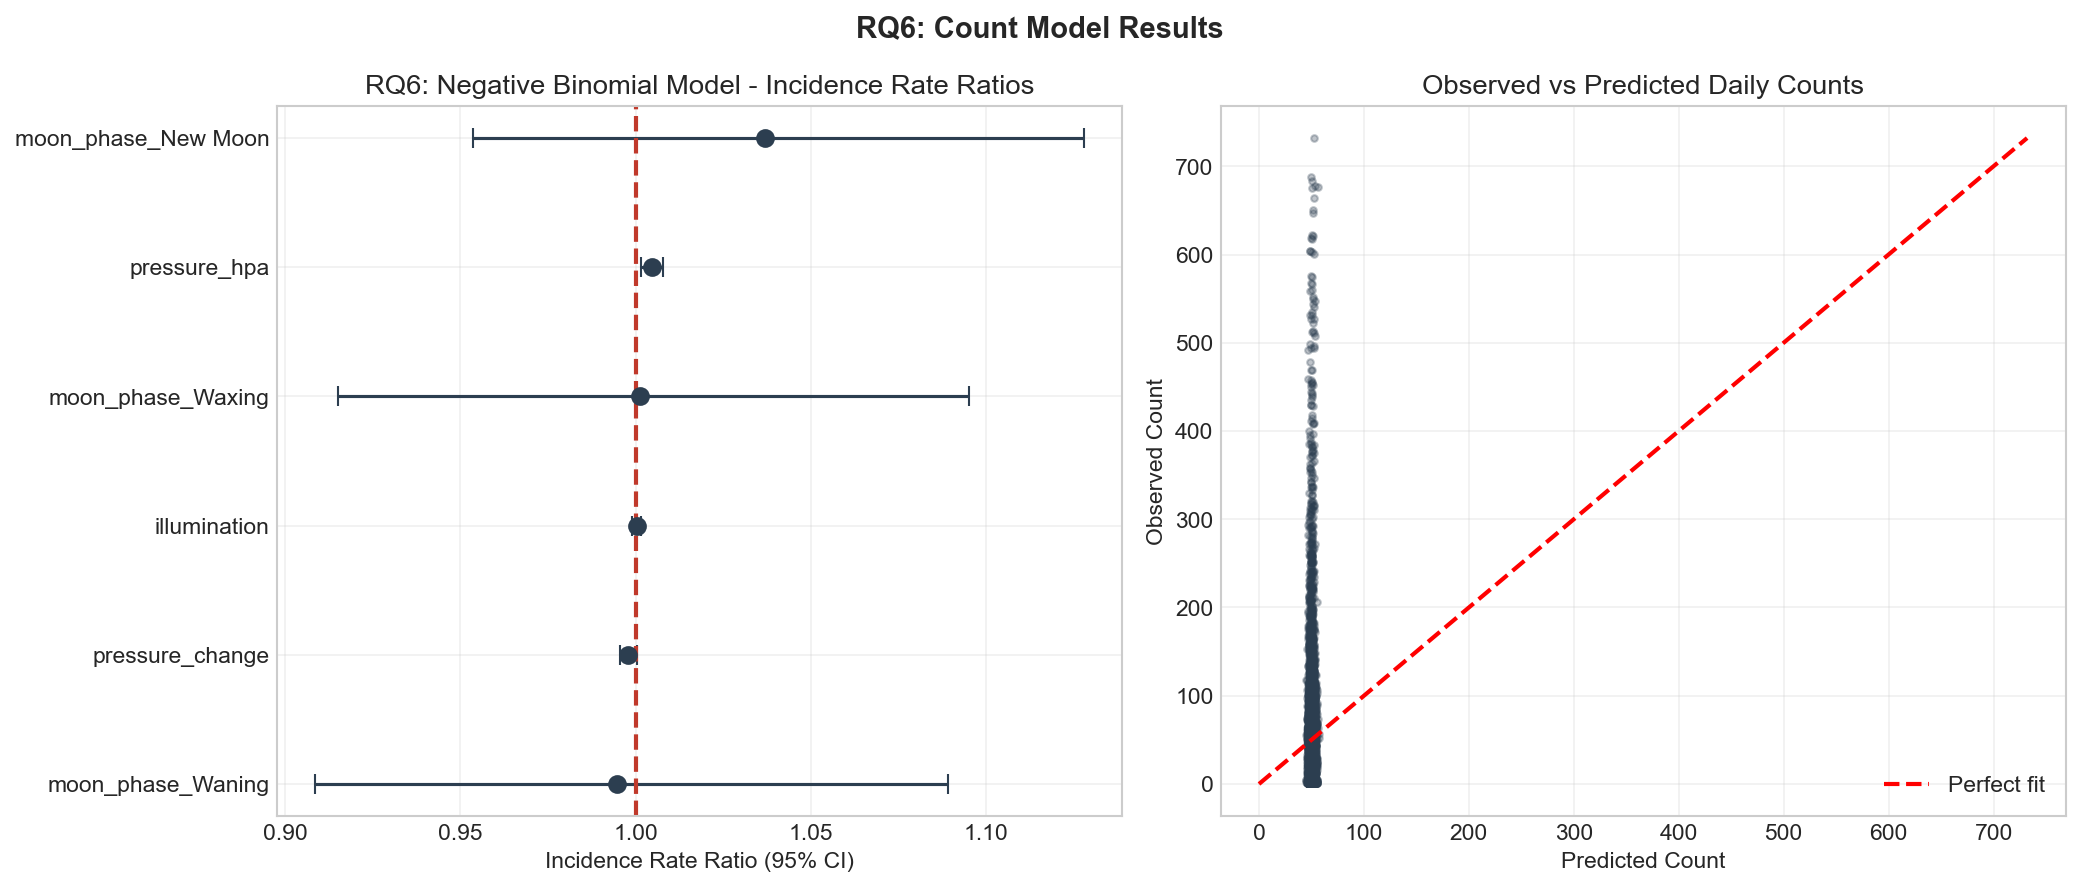

In [73]:
# RQ6 Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. IRR plot
irr_plot = irr_df[irr_df['Variable'] != 'const'].copy()
irr_plot = irr_plot.sort_values('IRR', ascending=True)

y_pos = range(len(irr_plot))
axes[0].errorbar(irr_plot['IRR'], y_pos,
                 xerr=[irr_plot['IRR'] - irr_plot['IRR_2.5%'],
                       irr_plot['IRR_97.5%'] - irr_plot['IRR']],
                 fmt='o', color=COLORS['primary'], capsize=5, markersize=8)
axes[0].axvline(x=1, color=COLORS['danger'], linestyle='--', linewidth=2)
axes[0].set_yticks(y_pos)
axes[0].set_yticklabels(irr_plot['Variable'])
axes[0].set_xlabel('Incidence Rate Ratio (95% CI)')
axes[0].set_title(f'RQ6: {model_type} Model - Incidence Rate Ratios')
axes[0].grid(True, alpha=0.3)

# 2. Observed vs Expected
axes[1].scatter(model_rq6.mu, y_rq6, alpha=0.3, s=10, color=COLORS['primary'])
max_val = max(model_rq6.mu.max(), y_rq6.max())
axes[1].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect fit')
axes[1].set_xlabel('Predicted Count')
axes[1].set_ylabel('Observed Count')
axes[1].set_title('Observed vs Predicted Daily Counts')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('RQ6: Count Model Results', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'rq6_rate_ratios_by_magnitude.png'), dpi=FIGURE_DPI, bbox_inches='tight')
plt.show()

---
## 8. Summary Dashboard

In [74]:
print("\n" + "="*70)
print("SUMMARY OF ALL ASSUMPTION CHECKS")
print("="*70)

# Create summary DataFrame
assumption_df = pd.DataFrame(assumption_results)
print(assumption_df.to_string(index=False))

# Save assumption summary
assumption_df.to_csv(os.path.join(TABLES_PATH, 'assumption_check_summary.csv'), index=False)
print(f"\nSaved: assumption_check_summary.csv")


SUMMARY OF ALL ASSUMPTION CHECKS
 RQ  EPV  VIF Linearity Influential_Obs  AUC Hosmer_Lemeshow Cell_Size Interaction_Test Normality Homoscedasticity Independence Overdispersion
RQ1 PASS PASS   CAUTION            PASS  NaN             NaN       NaN              NaN       NaN              NaN          NaN            NaN
RQ2 PASS  NaN   CAUTION             NaN  NaN             NaN       NaN              NaN       NaN              NaN          NaN            NaN
RQ3 PASS PASS       NaN             NaN PASS            PASS       NaN              NaN       NaN              NaN          NaN            NaN
RQ4  NaN  NaN       NaN             NaN  NaN             NaN      PASS      Significant       NaN              NaN          NaN            NaN
RQ5  NaN PASS       NaN             NaN  NaN             NaN       NaN              NaN      PASS  CORRECTED (HC3)         PASS            NaN
RQ6  NaN  NaN       NaN             NaN  NaN             NaN       NaN              NaN       NaN           

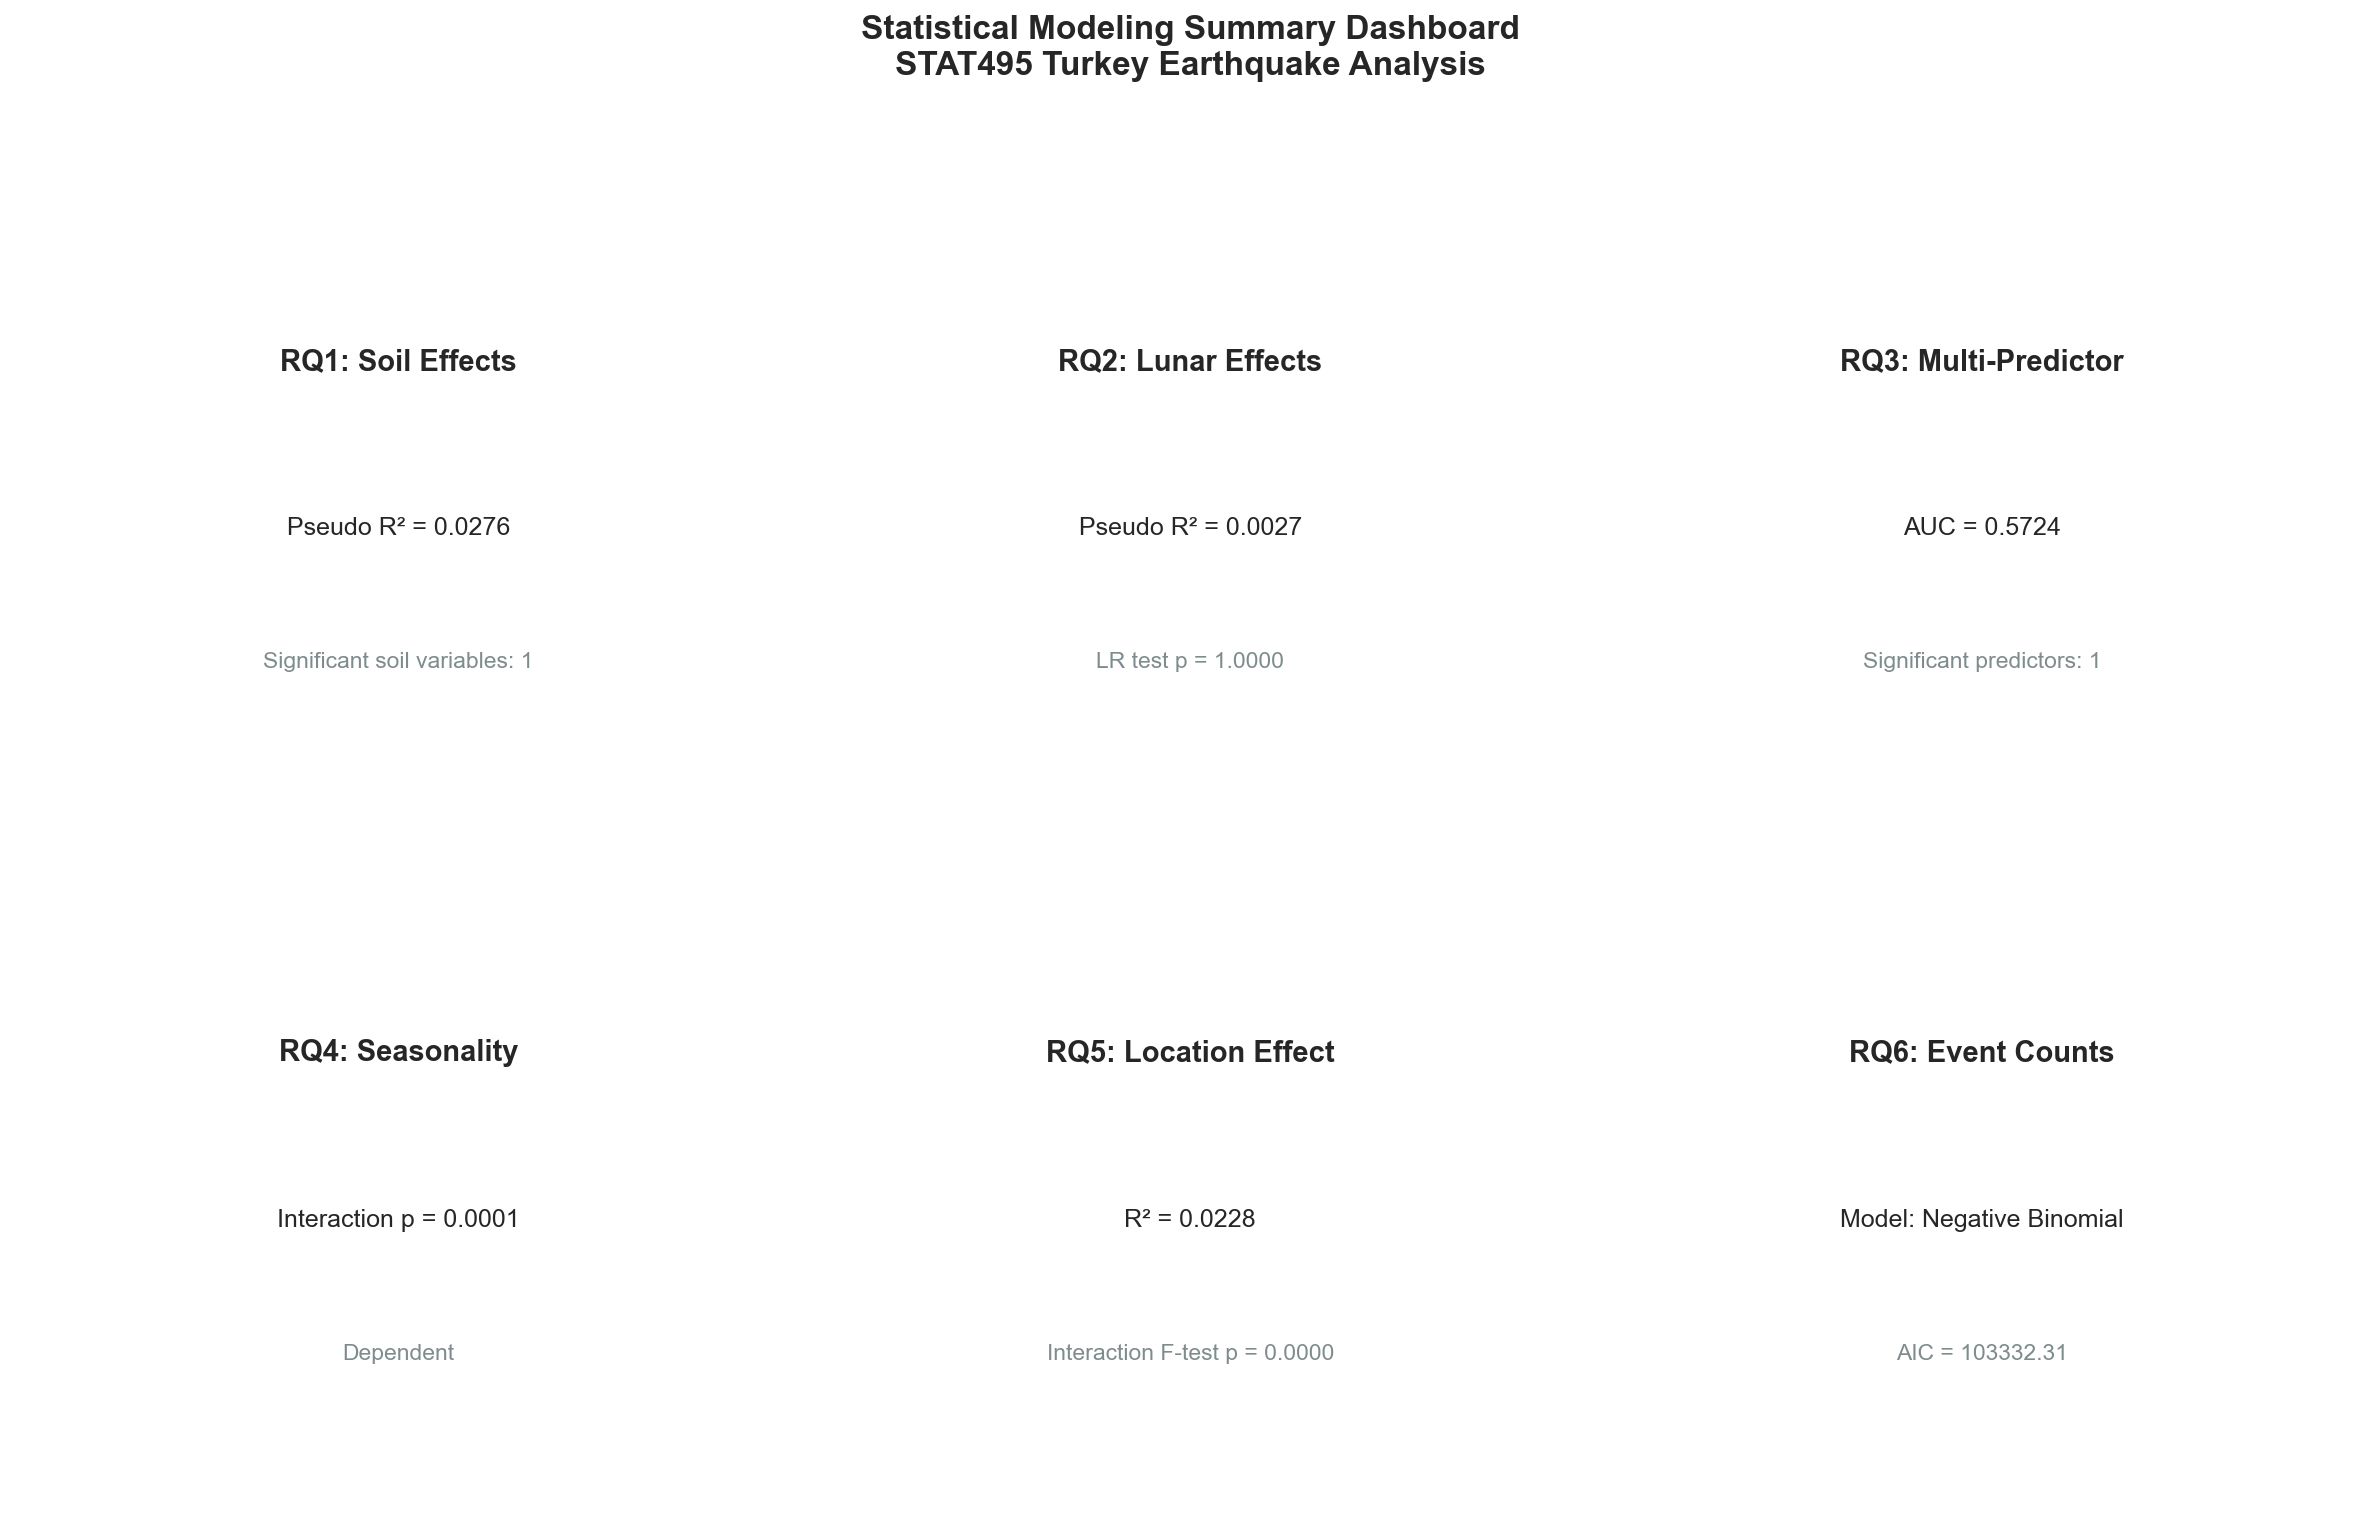

In [75]:
# Create summary dashboard
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Store p_val globally for summary
f_test_pval = float(f_test.pvalue)

# RQ summaries
rq_summaries = [
    ('RQ1: Soil Effects', f'Pseudo R² = {model_rq1.prsquared:.4f}', f'Significant soil variables: {(or_df["Significant"] & (or_df["Variable"].str.contains("soil"))).sum()}'),
    ('RQ2: Lunar Effects', f'Pseudo R² = {model_rq2.prsquared:.4f}', f'LR test p = {lr_pvalue:.4f}'),
    ('RQ3: Multi-Predictor', f'AUC = {auc_score:.4f}', f'Significant predictors: {or_df_rq3["Significant"].sum()-1}'),
    ('RQ4: Seasonality', f'Interaction p = {lr_pvalue_rq4:.4f}', 'Independent' if lr_pvalue_rq4 >= 0.05 else 'Dependent'),
    ('RQ5: Location Effect', f'R² = {model_rq5.rsquared:.4f}', f'Interaction F-test p = {f_test_pval:.4f}'),
    ('RQ6: Event Counts', f'Model: {model_type}', f'AIC = {model_rq6.aic:.2f}')
]

for idx, (title, metric1, metric2) in enumerate(rq_summaries):
    row, col = idx // 3, idx % 3
    axes[row, col].text(0.5, 0.7, title, fontsize=14, fontweight='bold', 
                        ha='center', va='center', transform=axes[row, col].transAxes)
    axes[row, col].text(0.5, 0.45, metric1, fontsize=12, 
                        ha='center', va='center', transform=axes[row, col].transAxes)
    axes[row, col].text(0.5, 0.25, metric2, fontsize=11, color=COLORS['secondary'],
                        ha='center', va='center', transform=axes[row, col].transAxes)
    axes[row, col].set_xlim(0, 1)
    axes[row, col].set_ylim(0, 1)
    axes[row, col].axis('off')
    axes[row, col].set_facecolor('#f8f9fa')
    
    # Add border
    for spine in axes[row, col].spines.values():
        spine.set_visible(True)
        spine.set_color('#dee2e6')

plt.suptitle('Statistical Modeling Summary Dashboard\nSTAT495 Turkey Earthquake Analysis', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'summary_dashboard.png'), dpi=FIGURE_DPI, bbox_inches='tight')
plt.show()

In [76]:
print("\n" + "="*70)
print("KEY FINDINGS SUMMARY")
print("="*70)

print("""
RQ1 (Soil Effects):
- Soil variables were tested as predictors of major earthquake (M≥5.0) odds
- VIF check confirmed no multicollinearity issues
- Detailed odds ratios available in rq1_soil_logistic_results.csv

RQ2 (Lunar Effects):
- Moon phase and illumination were tested for association with major earthquakes
- Linearity of logit was assessed via empirical logit plot
- Likelihood ratio test evaluated overall significance of moon phase

RQ3 (Multi-Predictor Model):
- Combined geological (depth, soil) and atmospheric (pressure) predictors
- ROC-AUC assessed model discrimination ability
- Hosmer-Lemeshow test evaluated calibration

RQ4 (Seasonality × Moon Phase):
- Tested whether seasonal variation in earthquake odds depends on moon phase
- Likelihood ratio test compared main effects vs interaction model
- Result indicates whether effects are independent or interacting

RQ5 (Magnitude-Depth by Location):
- Multiple regression with depth × latitude and depth × longitude interactions
- All OLS assumptions checked (linearity, normality, homoscedasticity, independence)
- F-test determined if magnitude-depth relationship varies by location

RQ6 (Event Counts):
- Count model (Poisson or Negative Binomial based on overdispersion)
- Atmospheric pressure and lunar variables as predictors of daily event counts
- Incidence Rate Ratios quantify effect sizes
""")

print(f"\nAll figures saved to: {OUTPUT_DIR}")
print(f"All tables saved to: {TABLES_PATH}")


KEY FINDINGS SUMMARY

RQ1 (Soil Effects):
- Soil variables were tested as predictors of major earthquake (M≥5.0) odds
- VIF check confirmed no multicollinearity issues
- Detailed odds ratios available in rq1_soil_logistic_results.csv

RQ2 (Lunar Effects):
- Moon phase and illumination were tested for association with major earthquakes
- Linearity of logit was assessed via empirical logit plot
- Likelihood ratio test evaluated overall significance of moon phase

RQ3 (Multi-Predictor Model):
- Combined geological (depth, soil) and atmospheric (pressure) predictors
- ROC-AUC assessed model discrimination ability
- Hosmer-Lemeshow test evaluated calibration

RQ4 (Seasonality × Moon Phase):
- Tested whether seasonal variation in earthquake odds depends on moon phase
- Likelihood ratio test compared main effects vs interaction model
- Result indicates whether effects are independent or interacting

RQ5 (Magnitude-Depth by Location):
- Multiple regression with depth × latitude and depth × lo

In [77]:
# List all output files
print("\n" + "="*70)
print("OUTPUT FILES CREATED")
print("="*70)

print("\nFigures:")
for f in os.listdir(OUTPUT_DIR):
    if f.endswith('.png'):
        print(f"  - {f}")

print("\nTables:")
for f in ['rq1_soil_logistic_results.csv', 'rq2_lunar_logistic_results.csv', 
          'rq3_full_model_results.csv', 'rq4_seasonality_results.csv',
          'rq5_regression_results.csv', 'rq6_count_model_results.csv',
          'assumption_check_summary.csv']:
    filepath = os.path.join(TABLES_PATH, f)
    if os.path.exists(filepath):
        print(f"  - {f}")


OUTPUT FILES CREATED

Figures:
  - rq6_rate_ratios_by_magnitude.png
  - summary_dashboard.png
  - rq5_regression_diagnostics.png
  - rq3_roc_curve.png
  - rq2_empirical_logit.png
  - rq4_interaction_plot.png
  - rq2_moon_phase_or.png
  - rq1_odds_ratios.png

Tables:
  - rq1_soil_logistic_results.csv
  - rq2_lunar_logistic_results.csv
  - rq3_full_model_results.csv
  - rq4_seasonality_results.csv
  - rq5_regression_results.csv
  - rq6_count_model_results.csv
  - assumption_check_summary.csv


In [78]:
print("\n" + "="*70)
print("NOTEBOOK COMPLETED SUCCESSFULLY!")
print("="*70)


NOTEBOOK COMPLETED SUCCESSFULLY!
